# Технологии искусственного интеллекта. Семестр 1

© Петров М.В., старший преподаватель кафедры суперкомпьютеров и общей информатики, Самарский университет

## Лекция 6. Градиентный бустинг

### Содержание

1. [Введение](#6.1-Введение)
2. [$AdaBoost$](#6.2-$AdaBoost$)
3. [Градиентный бустинг](#6.3-Градиентный-бустинг)
4. [$XGBoost$](#6.4-$XGBoost$)
5. [$CatBoost$](#6.5-$CatBoost$)
6. [Датасет `Rain in Australia`](#6.6-Датасет-Rain-in-Australia)
7. [Подготовка данных](#6.7-Подготовка-данных)
8. [Классификация](#6.8-Классификация)
9. [Важность признаков](#6.9-Важность-признаков)
10. [Разное](#6.10-Разное)

### 6.1 Введение

Источники:
- [Открытый курс машинного обучения. Тема 10. Градиентный бустинг @ Хабр](https://habr.com/ru/companies/ods/articles/327250/)
- [Алгоритм AdaBoost](https://habr.com/ru/companies/otus/articles/503888/)
- [Бустинг, AdaBoost @ ИТМО](https://neerc.ifmo.ru/wiki/index.php?title=%D0%91%D1%83%D1%81%D1%82%D0%B8%D0%BD%D0%B3,_AdaBoost)
- [XGBoost @ ИТМО](https://neerc.ifmo.ru/wiki/index.php?title=XGBoost)
- [Градиентный бустинг. Реализация с нуля на Python и разбор особенностей его модификаций (XGBoost, CatBoost, LightGBM) @ Хабр](https://habr.com/ru/articles/799725/)
- [LightGBM @ GitHub](https://github.com/Microsoft/LightGBM)
- [Разбираем особенности алгоритмов CatBoost и LightGBM: какой от них профит @ Хабр](https://habr.com/ru/companies/tochka/articles/751012/)
- [Туториал по использованию библиотеки CatBoost @ GitHub](https://github.com/catboost/tutorials/blob/master/ru/ml_session_2018_tutorial_ru.ipynb)
- [Mastering Gradient Boosting with CatBoost @ GitHub](https://github.com/catboost/tutorials/blob/master/events/2019_pydata_london/pydata_london_2019.ipynb)
- [CatBoost @ Хабр](https://habr.com/ru/companies/otus/articles/778714/)
- [Быстрый градиентный бустинг с CatBoost @ Хабр](https://habr.com/ru/companies/otus/articles/527554/)
- [sklearn.ensemble.AdaBoostClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)
- [sklearn.ensemble.GradientBoostingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)
- [CatBoost tutorials](https://catboost.ai/en/docs/concepts/tutorials)
- [Градиентный бустинг с CATBOOST (часть 3/3) @ Хабр](https://habr.com/ru/articles/648939/)
- [Что внутри черного ящика: понимаем работу ML-модели с помощью SHAP @ Хабр](https://habr.com/ru/companies/wunderfund/articles/739744/)


***Бустинг*** &ndash; ансамблевый метод машинного обучения, целью которого является объединение нескольких *слабых* моделей предсказания для создания одной *сильной*. Слабая модель &ndash; это такая, которая выполняет предсказания немного лучше, чем наугад, в то время как сильная модель обладает высокой предсказательной способностью. Цель бустинга &ndash; улучшить точность предсказаний.

Бустинг работает путём последовательного добавления моделей в ансамбль. Каждая следующая модель строится таким образом, чтобы исправлять ошибки, сделанные предыдущими моделями. Это достигается путём фокусировки на наиболее проблемных данных, которые были неверно классифицированы или предсказаны ранее. Одной из основных фич бустинга является динамическое взвешивание обучающих данных. После каждого этапа обучения модели в ансамбле данные, на которых были допущены ошибки, получают больший вес. Это означает, что последующие модели уделяют больше внимания именно этим трудным случаям. Несмотря на свою мощь, бустинг может быть склонен к переобучению, особенно если в ансамбле слишком много моделей или они слишком сложные. Для контроля переобучения используется ранняя остановка (*early stopping*).

Исходные алгоритмы, предложенные Робертом Шапире (рекурсивное доминирование, англ. *recursive majority gate formulation*) и Йоавом Фройндом (бустинг по доминированию), не были адаптивными и не могли дать полного преимущества слабых обучений. Шапире и Фройнд затем разработали ***AdaBoost*** (*Adaptive Boosting*) &ndash; адаптивный алгоритм бустинга, который выиграл престижную премию Гёделя.

### 6.2 $AdaBoost$

Слабый обучающий алгоритм или классификатор &ndash; это обучающий алгоритм, который работает лучше, чем случайное угадывание, и работать хорошо он будет в случае переобучения, поскольку при большом наборе слабых классификаторов, любой слабый классификатор будет работать лучше, чем случайная выборка. В качестве слабого классификатора часто используется обычный порог (*threshold*) по определённому признаку. Если признак лежит выше порогового значения, чем было спрогнозировано, он относится к положительной области, в противном случае &ndash; к отрицательной.

$AdaBoost$ означает «Adaptive Boosting» или адаптивный бустинг. Он превращает слабые обучающие алгоритмы в сильные для решения проблем классификации. Уравнение *сильного* классификатора выглядит как линейная комбинация *слабых* классификаторов:

$$
\newcommand{\argminu}[1]{\underset{#1}{\mathrm{argmin}}\,}
$$

$$
f(x) = \displaystyle\sum_{t = 1}^{T}\alpha_t h_t(x),
$$

где $h_t(x): X \rightarrow \{-1, +1\}$ &ndash; $t$-ый слабый классификатор, $\alpha_t$ &ndash; его вес.

$H(x) = sign\left(f(x)\right)$ &ndash; *сильный* окончательный классификатор.

#### Алгоритм

Пусть у нас есть $m$ точек: $(x_1, y_1), \dots, (x_m, y_m), x_i \in X, y_i \in \{-1, +1\}$.  
Инициализация весов $1$-го классификатора: $D_1(i) = \displaystyle\frac{1}{m}$.  
Для $t = 1, \dots, T$:
- $h_t(x) = \argminu{h_t \in H}\epsilon_t, \epsilon_t = \displaystyle\sum_{i = 1}^{m}D_t(i)\left[y_i \neq h_t(x_i)\right]$
- $\alpha_t = \displaystyle\frac{1}{2} \log{\displaystyle\frac{1 - \epsilon_t}{\epsilon_t}}$
- $D_{t + 1}(i) = \displaystyle\frac{D_t(i) \exp\left(-\alpha_t y_i h_t(x_i)\right)}{Z_t}$, $Z_t$ &ndash; нормализующий параметр:  
  $Z_t = \displaystyle\sum_{i = 1}^{m} D_{t + 1}(i) = \displaystyle\sum_{i = 1}^{m} D_t(i) \exp\left(-\alpha_t y_i h_t(x_i)\right) = 1$
   > $\exp\left(-\alpha_t y_i h_t(x_i)\right) = \begin{cases}< 1, & y_i = h_t(x_i) \\ > 1, & y_i \neq h_t(x_i)\end{cases}$
- $F_t(x) = F_{t - 1}(x) + \alpha_t h_t(x)$  

Таким образом, после выбора оптимального классификатора $h_{t}$ для распределения $D_{t}$, объекты $x_{i}$, которые классификатор $h_{t}$ идентифицирует корректно, имеют веса меньшие, чем те, которые идентифицируются некорректно. Следовательно, когда алгоритм тестирует классификаторы на распределении $D_{t+1}$, он будет выбирать классификатор, который лучше идентифицирует объекты, неверно распознаваемые предыдущим классификатором.

$AdaBoost$ можно использовать для распознавания лиц, поскольку он является стандартным алгоритмом для таких задач. Он использует каскад отбраковки, состоящий из нескольких слоев классификаторов. Когда область распознавания не обнаруживает лица ни на одном слое, она отбраковывается. Первый классификатор в области отбрасывает отрицательную область, чтобы свести стоимость вычислений к минимуму. Несмотря на то, что $AdaBoost$ используется для объединения слабых классификаторов, принципы $AdaBoost$ также используются для поиска лучших признаков для каждого слоя в каскаде.

#### Достоинства и недостатки

##### Достоинства

- Простота реализации
- Хорошая обобщающая способность. В реальных задачах удаётся строить композиции, превосходящие по качеству базовые алгоритмы. Обобщающая способность может улучшаться по мере увеличения числа базовых алгоритмов
- Время построения композиции практически полностью определяется временем обучения базовых алгоритмов
- Возможность идентифицировать выбросы. Это наиболее «трудные» объекты $x_i$, для которых в процессе наращивания композиции веса принимают наибольшие значения

##### Недостатки

- Склонен к переобучению при наличии значительного уровня шума в данных
- Требует достаточно длинных обучающих выборок. Другие методы линейной коррекции, в частности, бэггинг, способны строить алгоритмы сопоставимого качества по меньшим выборкам данных
  > Бэггинг &ndash; простая техника, в которой мы строим независимые модели и комбинируем их, используя некоторую модель усреднения (например, взвешенное среднее, голосование большинства или нормальное среднее).
  > Обычно берут случайную подвыборку данных для каждой модели, так все модели немного отличаются друг от друга. Выборка строится по модели выбора с возвращением. Из-за того что данная техника использует множество некореллириющих моделей для построения итоговой модели, это уменьшает variance. Примером бэггинга служит модель случайного леса (Random Forest).

### 6.3 Градиентный бустинг

В 1999 году от Jerome Friedman появилось обобщение наработок алгоритмов бустинга &ndash; градиентный бустинг, он же *Gradient Boosting (Machine)*, он же *GBM*. Этой работой Friedman сразу задал статистическую базу для создания многих алгоритмов, предоставив общий подход бустинга как оптимизации в функциональном пространстве.

Пусть у нас есть $m$ пар признаков $x$ и целевых переменных $y$: $\left\{(x_i, y_i)\right\}, i = \overline{1, n}$, на котором мы будем восстанавливать зависимость вида $y = f(x)$. Восстанавливать будем приближением $\hat f(x)$, а для понимания, какое приближение лучше, у нас также будет функция потерь $L(y, f)$, которую мы будем минимизировать:

$$
\begin{align*}
&y \approx \hat f(x) \\
&\hat f(x) = \argminu{f(x)} L\left(y, f(x)\right)
\end{align*}
$$

Функция $L(y, f)$ должна быть дифференцируемой. Будем искать наши приближения $\hat f(x)$ так, чтобы в среднем минимизировать функцию потерь на тех данных, что есть:

$$
\hat f(x) = \argminu{f(x)}\mathbb{E}_{x,y}\left[L(y, f(x))\right]
$$

Функциональное пространство функций $f(x)$ бесконечномерно. Поэтому чтобы хоть как-то решить задачу, в машинном обучении обычно ограничивают пространство поиска каким-нибудь конкретным параметризованным семейством функций $f(x, \theta), \theta \in \mathbb{R}^d$. Это сильно упрощает задачу, так как она сводится к уже вполне решаемой оптимизации значений параметров:

$$
\begin{align*}
&\hat f(x) = f(x, \hat\theta), \\
&\hat\theta = \argminu{\theta}\mathbb{E}_{x,y}\left[L(y, f(x, \theta))\right]
\end{align*}
$$

Аналитические решения для получения оптимальных параметров $\hat \theta$ в одну строку существуют достаточно редко, поэтому параметры обычно приближают итеративно. Сначала нам надо выписать эмпирическую функцию потерь $L_{\theta}(\hat \theta)$, показывающую, насколько хорошо мы их оценили по имеющимся у нас данным. Также выпишем наше приближение $\hat \theta$ за $M$ итераций в виде суммы:

$$
\begin{align*}
&\hat \theta = \displaystyle\sum_{i = 1}^M \hat \theta_i, \\ 
&L_{\theta}(\hat \theta) = \displaystyle\sum_{i = 1}^N L\left(y_i, f(x_i, \hat \theta)\right)
\end{align*}
$$

Дело за малым &ndash; осталось только взять подходящий итеративный алгоритм, которым мы будем минимизировать $L_{\theta}(\hat \theta)$. Самый простой и часто используемый вариант &ndash; градиентный спуск.

***Градиентный спуск*** &ndash; это итеративный алгоритм оптимизации, используемый для минимизации функции, чаще всего функции потерь в контексте машинного обучения. Он работает путем нахождения направления, в котором функция потерь уменьшается наиболее быстро, и делает шаги в этом направлении для постепенного уменьшения значения функции потерь.

Виды градиентного спуска:
- *Пакетный градиентный спуск* (*Batch Gradient Descent*): вычисляет градиент функции потерь по всему обучающему набору данных. Это точно, но может быть очень медленным на больших наборах данных.
- *Стохастический градиентный спуск* (*Stochastic Gradient Descent*, $SGD$): вычисляет градиент для каждого обучающего примера по отдельности и обновляет параметры. Это быстро, но изменения параметров могут быть очень "шумными".
- *Мини-пакетный градиентный спуск* (*Mini-batch Gradient Descent*): компромисс между двумя предыдущими методами, вычисляет градиенты на небольших группах обучающих примеров.

Для него нужно выписать градиент $\nabla L_{\theta}(\hat \theta)$ и добавлять наши итеративные оценки $\hat \theta_i$ вдоль него (со знаком минус &ndash; мы же хотим уменьшить ошибку, а не нарастить). И все, надо только как-то инициализировать наше первое приближение $\hat \theta_0$ и выбрать, сколько итераций $M$ мы эту процедуру будем продолжать. В нашем неэффективном по памяти виде хранения приближений $\hat \theta$ наивный алгоритм будет выглядеть следующим образом:

1. Инициализировать начальное приближение параметров $\hat \theta = \hat \theta_0$
2. Для каждой итерации $t = 1, \dots, M$ повторять:
   - Вычислить градиент функции потерь $\nabla L_{\theta}(\hat \theta)$ при текущем приближении $\hat \theta$:  
     $\nabla L_{\theta}(\hat \theta) = \left[\displaystyle\frac{\partial L\left(y, f(x, \theta)\right)}{\partial \theta}\right]_{\theta = \hat{\theta}}$
   - Задать текущее итеративное приближение $\hat \theta_t$ на основе вычисленного градиента  
     $\hat \theta_t \leftarrow −\nabla L_{\theta}(\hat \theta)$
   - Обновить приближение параметров $\hat \theta$:
     $\hat \theta \leftarrow \hat \theta + \hat \theta_t = \displaystyle\sum_{i = 0}^t \hat \theta_i$
3. Сохранить итоговое приближение $\hat \theta$  
   $\hat \theta = \displaystyle\sum_{i = 0}^M \hat \theta_i$
4. Пользоваться найденной функцией $\hat f(x) = f(x, \hat \theta)$ по назначению.

<div align="center">
  <img src="Image/l6_1_1.gif" height="292" title="Градиентный спуск"/>
  <img src="Image/l6_1_2.gif" height="292" title="Градиентный спуск"/>
  
  Рисунок 1 &ndash; Градиентный спуск
</div>

#### Функциональный градиентный спуск

Представим, что мы можем проводить оптимизацию в функциональном пространстве и итеративно искать приближения $\hat f(x)$ в виде самих функций. Выпишем наше приближение в виде суммы инкрементальных улучшений, каждое из которых является функцией. Для удобства сразу будем считать эту сумму, начиная с начального приближения $\hat f_0(x)$:

$$
\hat f(x) = \displaystyle\sum_{i = 0}^M \hat f_i(x)
$$

Магии пока не случилось, мы просто решили, что будем искать наше приближение $\hat f(x)$ не в виде одной большой модели с кучей параметров (как, например, нейросеть), а в виде суммы функций, делая вид, что таким образом мы двигаемся в функциональном пространстве. Чтобы решить задачу, нам все равно придется ограничить свой поиск каким-то семейством функций $\hat f(x) = h(x, \theta)$. Но, во-первых, сумма моделей может быть сложнее, чем любая модель из этого семейства (сумму двух деревьев-пней глубины $1$ уже не приблизить одним пнем). Во-вторых, общая задача все еще происходит в функциональном пространстве. Сразу учтем, на каждом шаге для функций нам понадобится подбирать оптимальный коэффициент $\rho \in \mathbb{R}$. Для шага $t$ задача выглядит следующим образом:

$$
\begin{alignat*}{2}
&\hat f(x) &&= \displaystyle\sum_{i = 0}^{t - 1} \hat f_i(x), \\
&(\rho_t, \theta_t) &&= \argminu{\rho,\theta}\mathbb{E}_{x,y}\left[L\left(y, \hat f(x) + \rho \cdot h(x, \theta)\right)\right], \\
&\hat f_t(x) &&= \rho_t \cdot h(x, \theta_t)
\end{alignat*}
$$

А вот теперь время магии. Мы выписывали все наши задачи в общем виде, словно мы можем просто так брать и обучать какие угодно модели $h(x, \theta)$ относительно каких угодно функций потерь $L\left(y, f(x, \theta)\right)$. На практике это крайне сложно, поэтому был придуман простой способ свести задачу к чему-то решаемому. Зная выражение градиента функции потерь, мы можем посчитать его значения на наших данных. Так давайте обучать модели так, чтобы наши предсказания были наиболее скоррелированными с этим градиентом (со знаком минус). То есть будем решать задачу МНК-регрессии, пытаясь выправлять предсказания по этим остаткам. И для классификации, и для регрессии, и для ранжирования под капотом мы все время будем минимизировать квадрат разности между псевдо-остатками $r$ и нашими предсказаниями. Для шага $t$ итоговая задача выглядит следующим образом:

$$
\begin{alignat*}{2}
&\hat f(x) &&= \displaystyle\sum_{i = 0}^{t - 1} \hat f_i(x), \\
&r_{it} &&= -\left[\displaystyle\frac{\partial L\left(y_i, f(x_i)\right)}{\partial f(x_i)}\right]_{f(x) = \hat f(x)}, \quad i = \overline{1,n}, \\
&\theta_t &&= \displaystyle\argminu{\theta} \displaystyle\sum_{i = 1}^{n} \left(r_{it} - h(x_i, \theta)\right)^2, \\
&\rho_t &&= \argminu{\rho} \displaystyle\sum_{i = 1}^{n} L\left(y_i, \hat f(x_i) + \rho \cdot h(x_i, \theta_t)\right)
\end{alignat*}
$$

#### Классический $GBM$ алгоритм Friedman'а

Теперь у нас есть все необходимое, чтобы наконец выписать GBM алгоритм, предложенный Jerome Friedman в 1999 году. Мы все так же решаем общую задачу обучения с учителем. На вход алгоритма нужно собрать несколько составляющих:
- набор данных $\left\{(x_i, y_i)\right\}, i = \overline{1,n}$;
- число итераций $M$;
- выбор функции потерь $L(y, f)$ с выписанным градиентом;
- выбор семейства функций базовых алгоритмов $h(x, \theta)$, с процедурой их обучения;
- дополнительные гиперпараметры $h(x, \theta)$, например, глубина дерева у деревьев решений.

Единственный момент, который остался без внимания &ndash; начальное приближение $f_0(x)$. Для простоты, в качестве инициализации используют просто константное значение $\gamma$. Его, а также оптимальный коэффициент $\rho$ находят бинарным поиском, или другим `line search` алгоритмом относительно исходной функции потерь (а не градиента). Итак, $GBM$ алгоритм:

1. Инициализировать $GBM$ константным значением $\hat f(x) = \hat f_0, \hat f_0 = \gamma, \gamma \in \mathbb{R}$  
   $\hat f_0 = \argminu{\gamma} \displaystyle\sum_{i = 1}^{n} L(y_i, \gamma)$
2. Для каждой итерации $t = 1, \dots, M$ повторять:
   - Вычислить псевдо-остатки $r_t$:  
     $r_{it} = -\left[\displaystyle\frac{\partial L\left(y_i, f(x_i)\right)}{\partial f(x_i)}\right]_{f(x)=\hat f(x)}, \quad i = \overline{1,n}$
   - Построить новый базовый алгоритм $h_t(x)$ как регрессию на псевдо-остатках $\left\{(x_i, r_{it})\right\}, i = \overline{1,n}$
   - Найти оптимальный коэффициент $\rho_t$ при $h_t(x)$ относительно исходной функции потерь:  
     $\rho_t = \argminu{\rho} \displaystyle\sum_{i = 1}^{n} L\left(y_i, \hat f(x_i) + \rho \cdot h(x_i, \theta)\right)$
   - Сохранить $\hat f_t(x) = \rho_t \cdot h_t(x)$
   - Обновить текущее приближение $\hat f(x)$:  
     $\hat f(x) = \hat f(x) + \hat f_t(x) = \displaystyle\sum_{i = 0}^{t} \hat f_i(x)$
3. Скомпоновать итоговую $GBM$ модель $\hat f(x)$:  
   $\hat f(x) = \displaystyle\sum_{i = 0}^M \hat f_i(x)$

#### $LightGBM$

$LightGBM$ &ndash; это реализация градиентного бустинга с открытым исходным кодом, библиотека программного обеспечения и алгоритм машинного обучения. То есть проект очень похож на *Extreme Gradient Boosting* &ndash; $XGBoost$.

LightGBM была описана в статье 2017 года [LightGBM: A Highly Efficient Gradient Boosting Decision Tree](https://papers.nips.cc/paper/6907-lightgbm-a-highly-efficient-gradient-boosting-decision-tree). Реализация вводит две ключевые идеи: *GOSS* и *EFB*.

***Градиентная односторонняя выборка*** (***Gradient-based One-Side Sampling***, ***GOSS***) является модификацией градиентного бустинга, который фокусирует внимание на тех учебных примерах, которые приводят к большему градиенту, в свою очередь, ускоряя обучение и уменьшая вычислительную сложность метода. У нас есть некоторые наблюдения, в которых градиент большой. Обычно таргет на них хуже предсказывается (т.е. больший потенциал для улучшения качества модели), чем на наблюдениях, где градиент маленький.  Хотелось бы, обучаясь, обратить большее внимание на эти наблюдения, чем на наблюдения с маленьким градиентом.

***Объединение взаимоисключающих признаков*** (***Exclusive Feature Bundling***, ***EFB***) &ndash; связка взаимоисключающих признаков. Идея такая: вместо $k$-признаков, построить $p$-связок $p \leq k$ и использовать только их при нахождении оптимальной точки расщепления при построении деревьев. Причём построение этих связок осуществляется только один раз &ndash; в самом начале. Сложность этого действия $O(k^2)$.

### 6.4 $XGBoost$

***XGBoost*** (*eXtreme Gradient Boosting*) &ndash; это библиотека с открытым исходным кодом, используемая в машинном обучении и предоставляющая функциональность для решения задач, связанных с регуляризацией градиентного бустинга.

Основные особенности XGBoost, отличающие его от других алгоритмов градиентного бустинга, включают:
- умная штрафовка деревьев;
- пропорциональное уменьшение узлов листьев;
- метод Ньютона в оптимизации;
- дополнительный параметр рандомизации;
- реализация на одиночных, распределенных системах и out-of-core вычислениях;
- автоматический отбор признаков.

В отличие от $GBM$ в $XGboost$ изначальный прогноз регрессионного дерева устанавливается $f_0 (x) = 0.5$ и вместо пней с глубиной $3$ берутся более глубокие деревья с листьями в диапазоне от $8$ до $32$ как в случае регрессии, так и классификации, а к функции потерь добавляется регуляризация ($L_1$ или $L_2$ на выбор), которая штрафует дерево с высокой суммой нормы значений в листьях. Данная сумма представлена в виде целевой функции, расчёт значений которой аппроксимируется разложением в ряд Тейлора 2-го порядка.

#### Алгоритм

Пусть дано:
- набор данных $\left\{(x_i, y_i)\right\}, i = \overline{1,n}$;
- число итераций $M$;
- функция потерь $L(y, f)$ с выписанным градиентом;
- скорость обучения $\alpha$.

Сам алгоритм:

1. Инициализировать модель константным значением:
   $\hat f_0(x) = \argminu{\theta} \displaystyle\sum_{i = 1}^{n} L(y_i, \theta)$
2. Для каждой итерации $t = 1, \dots, M$ повторять:
   - Вычислить "градиенты" и "гессианы":  
     $\begin{aligned}g_t(x_i) &= \left[\displaystyle\frac{\partial L\left(y_i, f(x_i)\right)}{\partial f(x_i)}\right]_{f(x) = \hat f_{t - 1}(x)}, \quad i = \overline{1,n} \\
     h_t(x_i) &= \left[\displaystyle\frac{\partial^2 L\left(y_i, f(x_i)\right)}{\partial f^2(x_i)}\right]_{f(x)=\hat f_{t - 1}(x)}, \quad i = \overline{1,n}\end{aligned}$
   - Построить новый базовый алгоритм с использованием обучающего множества $\left\{(x_i, -\displaystyle\frac{\hat g_t(x_i)}{\hat h_t(x_i)})\right\}, i = \overline{1,n}$:  
     $\hat \varphi_t(x) = \argminu{\varphi \in \Phi} \displaystyle\sum_{i = 1}^{n} \displaystyle\frac{1}{2} \hat h_t(x_i) \left[-\displaystyle\frac{\hat g_t(x_i)}{\hat h_t(x_i)} - \varphi(x_i)\right]^2 \\
     \hat f_t(x) = \alpha \varphi_t(x)$
   - Обновить текущее приближение $\hat f(x)$:  
     $\hat f(x) = \hat f(x) + \hat f_{t - 1}(x)$
3. Скомпоновать итоговую модель $\hat f(x)$:  
   $\hat f(x) = \hat f_M(x) = \displaystyle\sum_{i = 0}^M \hat f_i(x)$

Функция для оптимизации градиентного бустинга:  
$$
L^t = \displaystyle\sum_{i = 1}^n L\left(y_i, \hat f_t(x_i)\right) + \Omega(f_t) = \displaystyle\sum_{i = 1}^n L\left(y_i, \hat f_{t - 1}(x_i) + f_t(x_i)\right) + \omega(f_t).
$$

$\omega(f)$ &ndash; регуляризация функции $f$:
$$
\omega(f) = \gamma T + \displaystyle\frac{1}{2} \lambda ||\omega||^2 = \gamma T + \displaystyle\frac{1}{2} \lambda \displaystyle\sum_{j = 1}^T \omega_j^2,
$$
где $T$ &ndash; количество вершин в дереве, $\omega$ &ndash; значения в листьях (*the vector of scores on leaves*), $\gamma$ и $\lambda$ &ndash; параметры регуляризации.

$\omega(f)$ отвечает за "сложность" построенного дерева:

$$
f_t(x) = \omega_{q(x)}, \omega \in R^T, q: R^d \rightarrow {1, 2, \ldots, T},
$$
где $\omega$ &ndash; значения в листьях, $q$ &ndash; функция, которая соотносит точку данных из набора данных в соответствующий лист дерева, $T$ &ndash; количество листьев.

Дальше с помощью разложения Тейлора до второго члена можем приблизить оптимизируемую функцию $L^t$ следующим выражением:
$$
\begin{alignat*}{2}
&L^t &&= \displaystyle\sum_{i = 1}^n L\left(y_i, \hat f_{t - 1}(x_i) + g_t(x_i) f_t(x_i) + \displaystyle\frac{1}{2} h_t(x_i) f_t^2(x_i)\right) + \Omega(f_t) =\\
&&&= \displaystyle\sum_{i = 1}^n L\left(y_i, \hat f_{t - 1}(x_i) + g_t(x_i) f_t(x_i) + \displaystyle\frac{1}{2} h_t(x_i) f_t^2(x_i)\right) + \gamma T + \displaystyle\frac{1}{2} \lambda \displaystyle\sum_{j = 1}^{T} \omega_j^2\\
&g_t(x_i) &&= \left[\displaystyle\frac{\partial L\left(y_i, f(x_i)\right)}{\partial f(x_i)}\right]_{f(x) = \hat f_{t - 1}(x)} \\
&h_t(x_i) &&= \left[\displaystyle\frac{\partial^2 L\left(y_i, f(x_i)\right)}{\partial f^2(x_i)}\right]_{f(x)=\hat f_{t - 1}(x)}
\end{alignat*}
$$

$L^t$ можно переписать в следующем виде:

$$
\begin{alignat*}{2}
&L^t &&= \displaystyle\sum_{i = 1}^n L\left(y_i, \hat f_{t - 1}(x_i) + g_t(x_i) f_t(x_i) + \displaystyle\frac{1}{2} h_t(x_i) f_t^2(x_i)\right) + \gamma T + \displaystyle\frac{1}{2} \lambda \displaystyle\sum_{j = 1}^{T} \omega_j^2 = \\
&&&= \displaystyle\sum_{j = 1}^T \left[ \left( \displaystyle\sum_{i \in I_j}g_i \right) \omega_j + \displaystyle\frac{1}{2} \left( \displaystyle\sum_{i \in I_j} h_i + \lambda \right) \omega_j^2 \right] + \lambda T, \\
&g_i &&= g_t(x_i), \\
&h_i &&= h_t(x_i),
\end{alignat*}
$$
где $I_j = \{i|q(x_i) = j\}$ &ndash; множество индексов точек из набора данных, присвоенных $j$-ому листу.

Пусть

$$
G_j = \displaystyle\sum_{i \in I_j} g_i, \\
H_j = \displaystyle\sum_{i \in I_j} h_i.
$$

Тогда

$$
L^T = \displaystyle\sum_{j = 1}^T \left[ G_j \omega_j + \displaystyle\frac{1}{2} \left( H_j + \lambda \right) \omega_j^2 \right] + \lambda T.
$$

Лучшие $\omega_j$ для структуры дерева $q(x)$ и $L^T$:

$$
\begin{alignat*}{2}
&\hat \omega_j &&= - \displaystyle\frac{G_j}{H_j + \lambda}, \\
&\hat L^T &&= - \displaystyle\frac{1}{2} \displaystyle\sum_{j = 1}^T \displaystyle\frac{G_j^2}{H_j + \lambda} + \gamma T.
\end{alignat*}
$$

Последнее уравнение используется для оценки качества построенного дерева $q(x)$. Чем меньше значение данного показателя, тем лучше структура построенного дерева.

Оптимизация одного уровня дерева &ndash; стоит ли нам разбивать лист (вершину) дерева на два или нет:

$$
Gain = \displaystyle\frac{1}{2} \left[ \displaystyle\frac{G_L^2}{H_L + \lambda} + \displaystyle\frac{G_R^2}{H_R + \lambda} - \displaystyle\frac{\left( G_L + G_R \right)^2}{H_L + H_R + \lambda} \right] - \gamma.
$$

В данном выражении: 
$$
\begin{align*}
Gain &= \text{<значение показателя в новом левом листе>} + \\
&+ \text{<значение показателя в новом правом листе>} - \\
&- \text{<значение показателя в текущем листе до разбиения>} - \\
&- \gamma.
\end{align*}
$$

Таким образом, если прирост информации меньше, чем $\gamma$, то лучше оставить текущий лист без разбиения. Что и есть прореживание или стрижка (*pruning*) дерева.

Более подробно алгоритм описан в [Introduction to Boosted Trees](https://xgboost.readthedocs.io/en/stable/tutorials/model.html).

#### Параметры

Все параметры описаны в [XGBoost Parameters](https://xgboost.readthedocs.io/en/stable/parameter.html).

Основные:
- `booster` &ndash; модель, используемая для бустинга. Может быть `gbtree` (дерево решений), `gblinear` (линейная модель с регуляризацией), `dart` (*DART: Dropouts meet Multiple Additive Regression Trees*). Значение по умолчанию `gbtree`.
   > `gblinear` отличается от моделей линейной регрессии, подробнее здесь: [Difference in regression coefficients of sklearn's LinearRegression and XGBRegressor @ stackexchange](https://stats.stackexchange.com/questions/448879/difference-in-regression-coefficients-of-sklearns-linearregression-and-xgbregre).  
   > `dart` дропает деревья в процессе обучения, чтобы избежать переобучения. Есть особенности с предсказанием таргета, подробнее здесь: [Additional parameters for Dart Booster](https://xgboost.readthedocs.io/en/stable/parameter.html#additional-parameters-for-dart-booster-booster-dart). Про особенности $DART$ можно почитать [DART booster](https://xgboost.readthedocs.io/en/stable/tutorials/dart.html).
- `device` &ndash; устройство, используемое для вычислений. Поддерживаются только GPU NVidia, [XGBoost GPU Support](https://xgboost.readthedocs.io/en/stable/gpu/index.html). Возможные значения `cpu`, `cuda`, `cuda:<номер GPU в системе>`, `gpu`, `gpu:<номер GPU в системе>`. Значение по умолчанию `cpu`.
- `verbosity` &ndash; уровень логирования: 0 (silent), 1 (warning), 2 (info), 3 (debug). Значение по умолчанию 1.
- `nthread` &ndash; количество потоков для параллельных вычислений. По умолчанию максимально доступное в системе.
   > В [документации](https://xgboost.readthedocs.io/en/stable/tutorials/param_tuning.html#reducing-memory-usage) при использовании `GridSearchCV` советуют отдать приоритет в плане параллельных вычислений библиотеке $XGBoost$, нежели запускать несколько экспериментов в параллель (параметр `n_jobs` у `GridSearchCV`). Плюс экономия памяти.

Параметры для бустинга на деревьях ([Parameters for Tree Booster](https://xgboost.readthedocs.io/en/stable/parameter.html#parameters-for-tree-booster)):
- `eta` или `learning_rate` &ndash; скорость обучения. Диапазон значений: $[0, 1]$. Значение по умолчанию $0.3$.
- `gamma` или `min_split_loss` &ndash; параметр регуляризации $\gamma$, который влияет на решение о сплите текущей вершины дерева. Диапазон значений: $[0, \infty]$. Значение по умолчанию $0$.
- `max_depth` &ndash; максимальная глубина дерева. Увеличение данного параметра приведет к усложнению структуры дерева и увеличит вероятность переобучения модели. Диапазон значений: $[0, \infty]$. Значение по умолчанию $6$. $0$ означает отсутствие ограничений на глубину дерева, что приведет к увеличению потребления памяти при обучении модели. Если значение параметра `tree_method` установлено `exact`, то необходимо указать число, отличное от $0$.
- `min_child_weight` &ndash; минимальное значение суммы весов (гессианов) в вершине. Если данная сумма меньше заданного значения параметра, то ветвление в данной вершине не будет осуществлено. Диапазон значений: $[0, \infty]$. Значение по умолчанию $1$.
- `subsample` &ndash; доля сэмплирования данных на каждой итерации бустинга. Значение $0.5$ означает, что будет случайным образом отобрана половина данных из обучающего набора перед построением нового дерева. Диапазон значений: $(0, 1]$. Значение по умолчанию $1$.
- `sampling_method` &ndash; метод сэмплирования:  
   + `uniform` &ndash; равномерное распределение, `subsample` $\geq 0.5$ &ndash; типичное значение для получения хороших результатов.
   + `gradient_based` &ndash; вероятность выбора пропорциональна регуляризованному абсолютному значению градиентов $\displaystyle\sqrt{g^2 + \lambda h^2}$. Значение `subsample` может быть выбрано вплоть до $0.1$ без потери точности модели. При этом `tree_method` $\rightarrow$ `hist`, `device` $\rightarrow$ `cuda`. Другие методы `tree_method` поддерживают только `uniform`.
- `lambda` или `reg_lambda` &ndash; параметр $L_2$ регуляризации. Диапазон значений: $[0, \infty]$. Значение по умолчанию $1$.
- `alpha` или `reg_alpha` &ndash; параметр $L_1$ регуляризации. Диапазон значений: $[0, \infty]$. Значение по умолчанию $0$.
- `tree_method` &ndash; алгоритм построения деревьев:
   + `auto` &ndash; то же самое, что и `hist`.
   + `exact` &ndash; "точное" решение. Для принятия решения о потенциальном сплите рассматриваются все данные выборки, что в результате дает более точный результат по сравнению с другими жадными алгоритмами, но и самый медленный.
   + `approx` &ndash; аппроксимация дерева решений. Используется оптимизация (*Weighted Quantile Sketch*) из [XGBoost: A Scalable Tree Boosting System](https://arxiv.org/pdf/1603.02754) и гистограмма градиентов.
   + `hist` &ndash; используется аппроксимация дерева решений из $LightGBM$ с некоторыми отличиями. Самый быстрый вариант алгоритма.  

  Подробнее в [Tree Methods](https://xgboost.readthedocs.io/en/stable/treemethod.html). Значение по умолчанию `auto`.
- `scale_pos_weight` &ndash; контролирует баланс между положительными и отрицательными весами, используется для несбалансированных классов. Типичное значение $\sum(\textit{отрицательные отсчеты}) / \sum(\textit{положительные отсчеты})$. Значение по умолчанию $1$.
- `max_delta_step` &ndash; данный параметр может помочь с несбалансированным датасетом. Подробнее в [Handle Imbalanced Dataset](https://xgboost.readthedocs.io/en/stable/tutorials/param_tuning.html#handle-imbalanced-dataset). Диапазон значений: $[0, \infty]$. Значение по умолчанию $1$.
- `objective` &ndash; функция потерь для решаемой задачи. По умолчанию значение `reg:squarederror`. Полный список возможных значений приведен в [Learning Task Parameters](https://xgboost.readthedocs.io/en/stable/parameter.html#learning-task-parameters). Для решения задачи классификации:
   + `binary:logistic` &ndash; логистическая регрессия для бинарной классификации, на выходе вероятность.
   + `multi:softmax` &ndash; мультиклассовая классификация с использованием `softmax`.
   + `multi:softprob` &ndash; мультиклассовая классификация с использованием `softmax`, возращает ***вектор*** вероятностей $ndata \times nclass$, который можно решейпнуть в матрицу $ndata \times nclass$.
- `eval_metric` &ndash; метрика для оценки работы модели на валидационной выборке. Значение по умолчанию определяется в зависимости от параметра `objective` (`rmse` для регрессии, `logloss` для классификации, например). Полный список возможных значений приведен в [Learning Task Parameters](https://xgboost.readthedocs.io/en/stable/parameter.html#learning-task-parameters).
- `early_stopping_rounds` &ndash; определяет максимальное количество итераций, в течение которых должна уменьшаться ошибка (улучшаться метрика) на валидационной выборке. Иначе процесс построения модели завершается.
- и другие.

$XGBoost$ поддерживает работу с категориальными признаками: [Categorical Data](https://xgboost.readthedocs.io/en/stable/tutorials/categorical.html). Может использоваться *one-hot encoding* или без кодирования. В последнем случае используется предикат с функцией принадлежности $value \in categories$. Есть два параметра:
- `max_cat_to_onehot` &ndash; задает значение порога. Если мощность признака (количество уникальных значений категориального признака) меньше порога, то используется *one-hot encoder*.
- `max_cat_threshold` &ndash; максимальное количество категорий, предполагаемое для каждого сплита. Помогает бороться с переобучением модели.

#### Предсказание

Раздел документации: [Prediction](https://xgboost.readthedocs.io/en/stable/prediction.html).

Для многоклассовой классификации $XGBoost$ строит отдельное дерево для каждого класса, и деревья для каждого отдельного класса называются группой деревьев. Возвращаемое значение (и его размерность) метода `.predict()` зависит от используемой модели и различных параметров.

При обучении модели с ранней остановкой в `sklearn` метод `.predict()` по умолчанию использует лучшую модель. В $XGBoost$ используется ***вся*** модель. Достичь похожего эффекта как в `sklearn` можно комбинацией аргумента `iteration_range` метода `.predict()` и номера лучшей итерации, извлеченного из модели:

```python
xgb_model = XGBClassifier(..., early_stopping_rounds=10)
xgb_model.fit(X_train, y_train)
best_iteration = xgb_model.get_booster().best_iteration
y_pred = xgb_model.predict(X_test, iteration_range=(0, best_iteration + 1))
```

#### $XGBoost$ и случайный лес

$XGBoost$ реализует градиентный бустинг, используя в качестве модели дерево решений. Однако, $XGBoost$ позволяет использовать в качестве модели для бустинга случайный лес. При использовании нативного API нужно задать определенные параметры: [Standalone Random Forest With XGBoost API](https://xgboost.readthedocs.io/en/stable/tutorials/rf.html#standalone-random-forest-with-xgboost-api). Также есть классы `XGBRFClassifier` и `XGBRFRegressor` для решения задачи классификации и регрессии с использованием случайного леса. Данные классы предоставляют API как в `scikit-learn`, но ***не реализуют градиентный бустинг***.

#### Проблема переобучения

Источник: [Control Overfitting](https://xgboost.readthedocs.io/en/stable/tutorials/param_tuning.html#control-overfitting).

В документации предлагается использовать 2 стратегии:
1. Управление сложностью построения модели.
   - Тюнинг параметров `max_depth`, `min_child_weight` и `gamma`.
2. Добавление "случайности", чтобы модель стала более устойчивой к шуму при ее обучении.
   - Тюнинг параметров `subsample` и `colsample_bytree`.
   - Уменьшение значения параметра `eta` и увеличение значения параметра `num_round` одновременно.

### 6.5 $CatBoost$

$CatBoost$ &ndash; это библиотека градиентного бустинга, созданная Яндексом. Она использует *небрежные* (*oblivious*) деревья решений, чтобы вырастить сбалансированное дерево. Одни и те же функции используются для создания левых и правых разделений (*split*) на каждом уровне дерева. По сравнению с классическими деревьями, небрежные деревья более эффективны при реализации на процессоре и просты в обучении.

Наиболее распространенными способами обработки категориальных данных в машинном обучении является *one-hot encoding* и *label encoding*. $CatBoost$ позволяет использовать категориальные признаки без необходимости их предварительно обрабатывать. При использовании $CatBoost$ лучше не использовать *one-hot encoding* для признаков с большой мощностью, поскольку это влияет на скорость обучения и на качество прогнозов. Вместо этого необходимо задать категориальные признаки с помощью параметра `cat_features` при инициализации модели.

$CatBoost$ использует счетчики для категориальных признаков. Это означает, что для каждой категории создаются числовые признаки, отражающие статистику по этим категориям. Например, для задачи классификации, это может быть доля положительных и отрицательных классов внутри каждой категории. Если у нас есть категориальный признак "город проживания", то счетчик для каждого города будет отражать долю клиентов, сделавших покупку, проживающих в этом городе.

Также $CatBoost$ умеет комбинировать несколько категориальных признаков в один.

#### Преимущества использования $CatBoost$

Есть несколько причин подумать об использовании $CatBoost$:
- $CatBoost$ позволяет проводить обучение на нескольких GPU.
- Библиотека позволяет получить отличные результаты с параметрами по умолчанию, что сокращает время, необходимое для настройки гиперпараметров.
- Обеспечивает повышенную точность за счет уменьшения переобучения.
- Возможность быстрого предсказания с применением модели $CatBoost$.
- Обученные модели $CatBoost$ можно экспортировать в $\textit{Core ML}$ для вывода на устройстве (iOS).
- Умеет под капотом обрабатывать пропущенные значения.
- Может использоваться для регрессионных и классификационных задач.

#### Параметры обучения

Общие параметры в $CatBoost$:
- `loss_function` или `objective` &ndash; показатель, используемый для обучения. Есть регрессионные показатели, такие как среднеквадратичная ошибка для регрессии и `logloss` для классификации.
- `eval_metric` &ndash; метрика, используемая для обнаружения переобучения.
- `custom_metric` &ndash; метрика, используемая для вывода в консоль во время обучения.
- `iterations` &ndash; максимальное количество построенных деревьев, по умолчанию $1000$. Альтернативные названия `num_boost_round`, `n_estimators` и `num_trees`.
- `learning_rate` или `eta` &ndash; скорость обучения, которая определяет, насколько быстро или медленно модель будет учиться. Значение по умолчанию обычно равно $0.03$.
- `random_seed` или `random_state` &ndash; случайное зерно, используемое для обучения.
- `l2_leaf_reg` или `reg_lambda` &ndash; коэффициент при члене регуляризации $L_2$ функции потерь. Значение по умолчанию &ndash; 3.0.
- `bootstrap_type` &ndash; определяет метод сэмплинга весов объектов, например это может быть Байес, Бернулли, многомерная случайная величина или Пуассон.
- `depth` или `max_depth` &ndash; глубина дерева.
- `grow_policy` &ndash; определяет, как будет применяться жадный алгоритм поиска. Может стоять в значении `SymmetricTree`, `Depthwise` или `Lossguide`. По умолчанию `SymmetricTree`. В `SymmetricTree` дерево строится уровень за уровнем, пока не достигнет необходимой глубины. На каждом шаге листья с предыдущего дерева разделяются с тем же условием. При выборе параметра `Depthwise` дерево строится шаг за шагом, пока не достигнет необходимой глубины. Листья разделяются с использованием условия, которое приводит к лучшему уменьшению потерь. В `Lossguide` дерево строится по листьям до тех пор, пока не будет достигнуто заданное количество листьев. На каждом шаге разделяется нетерминальный лист с лучшим уменьшением потерь.
- `min_data_in_leaf` или `min_child_samples` &ndash; это минимальное количество обучающих сэмплов в листе. Этот параметр используется только с политиками роста `Lossguide` и `Depthwise`.
- `max_leaves` или `num_leaves` &ndash; этот параметр используется только с политикой `Lossguide` и определяет количество листьев в дереве.
- `ignored_features` &ndash; указывает на признаки, которые нужно игнорировать в процессе обучения.
- `nan_mode` &ndash; метод работы с пропущенными значениями. Параметры `Forbidden`, `Min` и `Max`. При использовании `Forbidden` наличие пропущенных значений вызовет ошибку. При использовании параметра `Min` пропущенные значения будут приняты за минимальные значения для данного признака. В `Max` пропущенные значения будут приняты как максимальные значения для данного признака.
- `leaf_estimation_backtracking` &ndash; тип бэктрекинга, использующийся при градиентном спуске. По умолчанию используется `AnyImprovement`. `AnyImprovement` уменьшает шаг спуска до указанного значения в случае, если значение функции потерь на текущем шаге стало меньше, чем на последней итерации. `Armijo` уменьшает шаг спуска до тех пор, пока не будет выполнено условие Вольфе.
- `boosting_type` &ndash; схема бустинга. Она может быть простой для классической схемы градиентного бустинга или упорядоченной, что обеспечит лучшее качество на небольших наборах данных.
- `score_function` &ndash; тип оценки, используемой для выбора следующего разбиения при построении дерева. `Cosine` используется по умолчанию. Другие доступные варианты: `L2`, `NewtonL2` и `NewtonCosine`.
- `early_stopping_rounds` &ndash; количество итераций обучения для ранней остановки. Устанавливает тип детектора переобучения в `Iter` и останавливает обучение, когда значение метрики не улучшилось за установленное количество итераций.
- `classes_count` &ndash; количество классов для задач мультиклассификации.
- `task_type` &ndash; используете вы `CPU` или `GPU`. По умолчанию стоит `CPU`.
- `devices` &ndash; идентификаторы устройств `GPU`, которые будут использоваться для обучения.
- `cat_features` &ndash; массив с категориальными столбцами.
- `text_features` &ndash; используется для объявления текстовых столбцов в задачах классификации.

#### Сравнительный анализ алгоритмов бустинга
|   |CatBoost|XGBoost|LightGBM|
|---|--------|-------|--------|
|Основное предназначение|Оптимизирован для работы с категориальными данными|Всецело фокусируется на производительности и эффективности|Ориентирован на скорость и эффективность при работе с большими объемами данных|
|Обработка категориальных данных|Встроенная обработка без предварительного кодирования|Требует предварительного кодирования (например, one-hot encoding)|Требует предварительного кодирования, но обладает оптимизациями для категориальных признаков|
|Скорость обучения|Высокая, с поддержкой GPU|Высокая, с поддержкой GPU|Очень высокая, эффективно обрабатывает большие наборы данных|
|Предотвращение переобучения|Использует ordered boosting и разнообразные стратегии регуляризации|Поддерживает L1 и L2 регуляризацию|Использует механизмы, такие как exclusive feature bundling (EFB)|
|Работа с большими данными|Оптимизирован для эффективной работы с большими наборами данных|Хорошо масштабируется, но может быть неэффективен на очень больших наборах данных|Оптимизирован для обработки больших объемов данных с низкими требованиями к памяти|
|Поддержка языков программирования|Поддерживает основные языки, включая Python, R, Java|Широкая поддержка языков, включая Python, R, Java, Scala|Поддерживает Python, R, Java и другие языки|
|Сложность моделей|Генерирует более сложные модели, но с контролем переобучения|Позволяет настраивать сложность модели через гиперпараметры|Строит более легковесные модели с использованием гистограммного подхода|
|Интерпретируемость|Обеспечивает хорошую интерпретируемость, особенно при работе с категориальными данными|Обеспечивает средний уровень интерпретируемости|Интерпретируемость может быть затруднена из-за оптимизаций и более сложных структур|

- $CatBoost$ выделяется своей способностью эффективно обрабатывать категориальные данные без предварительного кодирования. Он обеспечивает высокую производительность и эффективное предотвращение переобучения.
- $XGBoost$ ориентирован на производительность и гибкость. Он предоставляет широкий спектр параметров для тонкой настройки моделей, но требует более тщательной предварительной обработки данных, особенно категориальных.
- $LightGBM$ является наиболее эффективным при работе с большими наборами данных благодаря своему гистограммному подходу к построению деревьев и оптимизациям, таким как *EFB*.

### 6.6 Датасет `Rain in Australia`

Датасет содержит данные о метеонаблюдениях в Австралии, цель - прогнозирование дождя на следующий день. Целевой признак - `RainTomorrow`.

| Column        | Meaning                                                                                                | Units               |
|---------------|--------------------------------------------------------------------------------------------------------|---------------------|
| Location      | The common name of the location of the weather station                                                 |                     |
| MinTemp       | Minimum temperature in the 24 hours to 9am. Sometimes only known to the nearest whole degree.          | degrees Celsius     |
| MaxTemp       | Maximum temperature in the 24 hours from 9am. Sometimes only known to the nearest whole degree.        | degrees Celsius     |
| Rainfall      | Precipitation (rainfall) in the 24 hours to 9am. Sometimes only known to the nearest whole millimetre. | millimetres         |
| Sunshine      | Bright sunshine in the 24 hours to midnight                                                            | hours               |
| WindGustDir   | Direction of strongest gust in the 24 hours to midnight                                                | 16 compass points   |
| WindGustSpeed | Speed of strongest wind gust in the 24 hours to midnight                                               | kilometres per hour |
| WindDir9am    | Wind direction averaged over 10 minutes prior to 9 am                                                  | compass points      |
| WindDir3pm    | Wind direction averaged over 10 minutes prior to 3 pm                                                  | compass points      |
| WindSpeed9am  | Wind speed averaged over 10 minutes prior to 9 am                                                      | kilometres per hour |
| WindSpeed3pm  | Wind speed averaged over 10 minutes prior to 3 pm                                                      | kilometres per hour |
| Humidity9am   | Relative humidity at 9 am                                                                              | percent             |
| Humidity3pm   | Relative humidity at 3 pm                                                                              | percent             |
| Pressure9am   | Atmospheric pressure reduced to mean sea level at 9 am                                                 | hectopascals        |
| Pressure3pm   | Atmospheric pressure reduced to mean sea level at 3 pm                                                 | hectopascals        |
| Cloud9am      | Fraction of sky obscured by cloud at 9 am                                                              | eighths             |
| Cloud3pm      | Fraction of sky obscured by cloud at 3 pm                                                              | eighths             |
| Temp9am       | Temperature at 9 am                                                                                    | degrees Celsius     |
| Temp3pm       | Temperature at 3 pm                                                                                    | degrees Celsius     |
| RainToday     | The rain for that day was 1mm or more                                                                  | Yes or No           |
| RainTomorrow  | The rain for that day was 1mm or more. The target variable to predict.                                 | Yes or No           |

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
# путь к папке с данными
data_path = "..\lecture_3\data"
# датасет: Rain in Australia: https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package
df = pd.read_csv(Path(data_path, 'weatherAUS.csv'))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

### 6.7 Подготовка данных

Более подробно процедуры предобработки данных описаны в лекциях 3-4.
> Отличие: 
> - предобработка только датафрейма без разделения на $X$, $y$ и обучающую, тестовую выборки;
> - на выходе 2 датафрейма: с категориальными признаками как есть и с закодированными категориальными признаками.

#### Функции для предобработки данных

In [2]:
from copy import deepcopy
from sklearn.preprocessing import MinMaxScaler


# Outliers bounds
def get_bounds(dataframe, col):
    iqr = dataframe[col].quantile(0.75) - dataframe[col].quantile(0.25)
    lower_bound = dataframe[col].quantile(0.25) - 1.5 * iqr
    upper_bound = dataframe[col].quantile(0.75) + 1.5 * iqr
    return lower_bound, upper_bound


# Clean outliers
def clean_data(df, bounds_dict: dict):
    df_clean = deepcopy(df)
    print(df_clean.shape)

    for k, v in bounds_dict.items():
        arr = np.array((df_clean[k] > v[0]) & (df_clean[k] < v[1])).reshape((-1, 1))
        print(f"{k}: bounds: {v}")
        print(f"  old: {df_clean[k].shape[0]}, new: {np.count_nonzero(arr)}, diff: {np.count_nonzero(arr) - df_clean[k].shape[0]}")
        df_clean = df_clean[(df_clean[k] > v[0]) & (df_clean[k] < v[1])]
    return df_clean


def preprocess_df_for_classification(df_in: pd.DataFrame):
    df = deepcopy(df_in)
    # Drop NaN in RainTomorrow
    df = df.drop(df[df['RainTomorrow'].isna()].index)
    # Cat cols
    cat_cols = [var for var in df.columns if df[var].dtype == 'object']
    cat_null = df[cat_cols].isnull().sum()
    cat_null_mode = df[cat_null[cat_null > 0].index].mode()
    print(f"Cat cols with NaNs mode: {cat_null_mode}")
    # Fill NaNs
    for col in cat_cols:
        df.fillna({col: df[col].mode()[0]}, inplace=True)
    # Print cat cols cardinality
    len_max = max([len(col) for col in cat_cols])
    for col in cat_cols:
        print(f"{col:<{len_max}} labels: {len(df[col].unique())}")
    # Split Date into Day, Month, Year
    df['Date'] = pd.to_datetime(df['Date'])
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day
    df.drop('Date', axis=1, inplace = True)
    cat_cols.remove('Date')
    # Num cols
    num_cols = [var for var in df.columns if not df[var].dtype == 'object']
    # Fill NaNs
    for col in num_cols:
        df.fillna({col: df[col].median()}, inplace=True)
    # Scale data in num cols
    mm_scaler = MinMaxScaler()
    df[num_cols] = mm_scaler.fit_transform(df[num_cols])
    num_cols_scaled = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']
    bounds_dict = dict()
    for col in num_cols_scaled:
        lb, ub = get_bounds(df, col)
        bounds_dict[col] = [lb, ub]
        print(f"{col:<13} outliers are values < {lb:.2f} or > {ub:.2f}")
    # Clean numerical data
    df = clean_data(df, bounds_dict)
    # Reset index
    # Split df into categorical cols as is and encoded, reset index
    df_cat_as_is = df.reset_index(drop=True)
    df_cat_encoded = deepcopy(df_cat_as_is)

    # Encode Location
    df_cat_encoded_loc_dummy = pd.get_dummies(df_cat_encoded.Location, prefix='Location')
    df_cat_encoded = df_cat_encoded.drop('Location', axis = 1)
    df_cat_encoded = df_cat_encoded.join(df_cat_encoded_loc_dummy)
    # Cat cols left
    cat_left = [var for var in df_cat_encoded.columns if df_cat_encoded[var].dtype == 'object']
    cat_left = ['WindGustDir', 'WindDir9am', 'WindDir3pm']
    # Encode cat cols
    df_cat_encoded_left_dummy = pd.get_dummies(data=df_cat_encoded[cat_left], columns=cat_left, drop_first=False)
    # df_cat_encoded_left = df_cat_encoded_left.drop(columns=cat_left, axis=1)
    df_cat_encoded = df_cat_encoded.join(df_cat_encoded_left_dummy)
    df_cat_encoded = df_cat_encoded.drop(columns=cat_left, axis=1)
    # Replace values
    # df.replace({'RainToday': {'No': 0, 'Yes': 1}}, inplace = True)
    # df.replace({'RainTomorrow': {'No': 0, 'Yes': 1}}, inplace = True)
    df_cat_encoded.replace({'RainToday': {'No': '0', 'Yes': '1'}}, inplace = True)
    df_cat_encoded.replace({'RainTomorrow': {'No': '0', 'Yes': '1'}}, inplace = True)
    df_cat_encoded['RainToday'] = df_cat_encoded['RainToday'].astype(int)
    df_cat_encoded['RainTomorrow'] = df_cat_encoded['RainTomorrow'].astype(int)

    return df_cat_as_is, df_cat_encoded

#### Осуществляем предобработку данных

Получаем 2 датафрейма:
- `df_cat_as_is` &ndash; с категориальными признаками как есть;
- `df_cat_encoded` &ndash; с закодированными категориальными признаками.

In [3]:
df_cat_as_is, df_cat_encoded = preprocess_df_for_classification(df)

Cat cols with NaNs mode:   WindGustDir WindDir9am WindDir3pm RainToday
0           W          N         SE        No
Date         labels: 3436
Location     labels: 49
WindGustDir  labels: 16
WindDir9am   labels: 16
WindDir3pm   labels: 16
RainToday    labels: 2
RainTomorrow labels: 2
MinTemp       outliers are values < 0.05 or > 0.92
MaxTemp       outliers are values < 0.14 or > 0.92
Rainfall      outliers are values < -0.00 or > 0.00
Evaporation   outliers are values < 0.01 or > 0.05
Sunshine      outliers are values < 0.51 or > 0.65
WindGustSpeed outliers are values < 0.02 or > 0.48
WindSpeed9am  outliers are values < -0.08 or > 0.28
WindSpeed3pm  outliers are values < -0.04 or > 0.47
Humidity9am   outliers are values < 0.18 or > 1.22
Humidity3pm   outliers are values < -0.05 or > 1.07
Pressure9am   outliers are values < 0.34 or > 0.89
Pressure3pm   outliers are values < 0.34 or > 0.88
Cloud9am      outliers are values < -0.17 or > 1.17
Cloud3pm      outliers are values < 0.11 or > 1

In [4]:
df_cat_as_is.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49870 entries, 0 to 49869
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Location       49870 non-null  object 
 1   MinTemp        49870 non-null  float64
 2   MaxTemp        49870 non-null  float64
 3   Rainfall       49870 non-null  float64
 4   Evaporation    49870 non-null  float64
 5   Sunshine       49870 non-null  float64
 6   WindGustDir    49870 non-null  object 
 7   WindGustSpeed  49870 non-null  float64
 8   WindDir9am     49870 non-null  object 
 9   WindDir3pm     49870 non-null  object 
 10  WindSpeed9am   49870 non-null  float64
 11  WindSpeed3pm   49870 non-null  float64
 12  Humidity9am    49870 non-null  float64
 13  Humidity3pm    49870 non-null  float64
 14  Pressure9am    49870 non-null  float64
 15  Pressure3pm    49870 non-null  float64
 16  Cloud9am       49870 non-null  float64
 17  Cloud3pm       49870 non-null  float64
 18  Temp9a

In [5]:
df_cat_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49870 entries, 0 to 49869
Columns: 118 entries, MinTemp to WindDir3pm_WSW
dtypes: bool(97), float64(19), int32(2)
memory usage: 12.2 MB


#### Разобьем данные на обучающую и тестовую выборки оба датафрейма

Сделаем разбиение один раз для датафрейма, например, с закодированными категориальными признаками: из `X_ce` и `y_ce` получим `X_ce_train`, `X_ce_test`, `y_ce_train`, `y_ce_test`).  
Далее `X_cat_train`, `y_cat_train`, `X_cat_test`, `y_cat_test` будут получены из `X_cat` и `y_cat` по индексам `X_ce_train`, `X_ce_test`, `y_ce_train`, `y_ce_test`.

In [6]:
from sklearn.model_selection import train_test_split

X_ce = df_cat_encoded.drop(['RainTomorrow'], axis=1)
y_ce = df_cat_encoded['RainTomorrow']
X_cat = df_cat_as_is.drop(['RainTomorrow'], axis=1)
y_cat = df_cat_as_is['RainTomorrow']

X_ce_train, X_ce_test, y_ce_train, y_ce_test = train_test_split(X_ce, y_ce, test_size = 0.2, random_state = 0)
X_cat_train = X_cat.loc[X_ce_train.index]
y_cat_train = y_cat.loc[y_ce_train.index]
X_cat_test = X_cat.loc[X_ce_test.index]
y_cat_test = y_cat.loc[y_ce_test.index]

print(f"Cat encoded X, y, train, test: {X_ce_train.shape, y_ce_train.shape, X_ce_test.shape, y_ce_test.shape}")
print(f"Cat as is   X, y, train, test: {X_cat_train.shape, y_cat_train.shape, X_cat_test.shape, y_cat_test.shape}")

Cat encoded X, y, train, test: ((39896, 117), (39896,), (9974, 117), (9974,))
Cat as is   X, y, train, test: ((39896, 24), (39896,), (9974, 24), (9974,))


#### Проверим, одинаковы ли данные в пересекающихся числовых колонках

Таргеты не сверяем, так как это категориальный признак (один содержит значения $\{No, Yes\}$, другой $\{0, 1\}$: $No \equiv 0, Yes \equiv 1$).

In [7]:
cols_intersected = X_cat_train.columns[X_cat_train.columns.isin(X_ce_train.columns)]
cols_intersected = cols_intersected.drop(['RainToday'])
print(f"Columns intersection: {cols_intersected}")
print("Intersected cols equality check:")
print(f"  X_cat_train & X_ce_train: {X_cat_train[cols_intersected].equals(X_ce_train[cols_intersected])}")
print(f"  X_cat_test & X_ce_test  : {X_cat_test[cols_intersected].equals(X_ce_test[cols_intersected])}")

Columns intersection: Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'Year', 'Month', 'Day'],
      dtype='object')
Intersected cols equality check:
  X_cat_train & X_ce_train: True
  X_cat_test & X_ce_test  : True


> `equals` возвращает `True`, если сравниваемые значения одинаковы при условии, что названия колонок и индексы совпадают.

In [8]:
X_cat_train[cols_intersected] == (X_ce_train[cols_intersected])

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,Year,Month,Day
3984,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
24980,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
35664,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
5676,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
5430,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21243,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
45891,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
42613,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
43567,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True


### 6.8 Классификация

#### $AdaBoost$

У классификатора [sklearn.ensemble.AdaBoostClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html) два основных гиперпараметра:
- `n_estimators` &ndash; максимальное количество классификаторов для бустинга, диапазон значений: $[1, \infty)$. Значение по умолчанию $50$.
- `learning_rate` &ndash; значение веса, применяемого к классификатору на каждой итерации бустинга, диапазон значений: $(0.0, \infty)$. Значение по умолчанию $1.0$.

In [9]:
import sklearn
from sklearn.ensemble import AdaBoostClassifier

abc_model = AdaBoostClassifier(n_estimators=100, algorithm="SAMME", random_state=777)
abc_model.fit(X_ce_train, y_ce_train)

AdaBoostClassifier(algorithm='SAMME', n_estimators=100, random_state=777)

In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
y_ce_pred = abc_model.predict(X_ce_test)
cr = classification_report(y_ce_test, y_ce_pred, digits=7)
print(cr)

              precision    recall  f1-score   support

           0  0.8781508 0.9716354 0.9225308      8426
           1  0.6328725 0.2661499 0.3747158      1548

    accuracy                      0.8621416      9974
   macro avg  0.7555117 0.6188926 0.6486233      9974
weighted avg  0.8400828 0.8621416 0.8375080      9974



In [11]:
abc_model = AdaBoostClassifier(n_estimators=1000, algorithm="SAMME", random_state=777)
abc_model.fit(X_ce_train, y_ce_train)
y_ce_pred = abc_model.predict(X_ce_test)
cr = classification_report(y_ce_test, y_ce_pred, digits=7)
print(cr)

              precision    recall  f1-score   support

           0  0.8814161 0.9721101 0.9245443      8426
           1  0.6549192 0.2881137 0.4001795      1548

    accuracy                      0.8659515      9974
   macro avg  0.7681677 0.6301119 0.6623619      9974
weighted avg  0.8462630 0.8659515 0.8431610      9974



In [12]:
abc_model = AdaBoostClassifier(n_estimators=2000, algorithm="SAMME", random_state=777)
abc_model.fit(X_ce_train, y_ce_train)
y_ce_pred = abc_model.predict(X_ce_test)
cr = classification_report(y_ce_test, y_ce_pred, digits=7)
print(cr)

              precision    recall  f1-score   support

           0  0.8812574 0.9715167 0.9241885      8426
           1  0.6496350 0.2874677 0.3985670      1548

    accuracy                      0.8653499      9974
   macro avg  0.7654462 0.6294922 0.6613777      9974
weighted avg  0.8453088 0.8653499 0.8426102      9974



In [13]:
import numpy as np
from sklearn.model_selection import GridSearchCV

abc_model_params = {
    'n_estimators': [1000],
    'learning_rate': np.arange(0.05, 1.05, 0.05)
}

abc_model_grid = GridSearchCV(
    abc_model, abc_model_params, cv = 5, n_jobs = -1, verbose = 3
)

abc_model_grid.fit(X_ce_train, y_ce_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=5,
             estimator=AdaBoostClassifier(algorithm='SAMME', n_estimators=2000,
                                          random_state=777),
             n_jobs=-1,
             param_grid={'learning_rate': array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
                         'n_estimators': [1000]},
             verbose=3)

In [14]:
print("Best model:")
print(f"  score : {abc_model_grid.best_score_}")
print(f"  params: {abc_model_grid.best_params_}")
y_ce_pred = abc_model_grid.predict(X_ce_test)
cr = classification_report(y_ce_test, y_ce_pred, digits=7)
print(cr)

Best model:
  score : 0.865174394188253
  params: {'learning_rate': 0.9000000000000001, 'n_estimators': 1000}
              precision    recall  f1-score   support

           0  0.8809473 0.9712794 0.9239106      8426
           1  0.6461988 0.2855297 0.3960573      1548

    accuracy                      0.8648486      9974
   macro avg  0.7635730 0.6284045 0.6599840      9974
weighted avg  0.8445135 0.8648486 0.8419859      9974



#### $GBM$

У классификатора [GradientBoostingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) три *основных* гиперпараметра:
- `n_estimators` &ndash; максимальное количество итераций бустинга, диапазон значений: $[1, \infty)$. Значение по умолчанию $100$.
- `learning_rate` &ndash; значение веса, применяемого к классификатору на каждой итерации бустинга, диапазон значений: $[0.0, \infty)$. Значение по умолчанию $0.1$.
- `max_depth` &ndash; мксимальное количество вершин в дереве, диапазон значений: $[1, \infty)$. Значение по умолчанию $3$.

In [15]:
from sklearn.ensemble import GradientBoostingClassifier

gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=777)
gb_model.fit(X_ce_train, y_ce_train)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=777)

In [16]:
y_ce_pred = gb_model.predict(X_ce_test)
cr = classification_report(y_ce_test, y_ce_pred, digits=7)
print(cr)

              precision    recall  f1-score   support

           0  0.8817633 0.9709233 0.9241979      8426
           1  0.6479885 0.2913437 0.4019608      1548

    accuracy                      0.8654502      9974
   macro avg  0.7648759 0.6311335 0.6630794      9974
weighted avg  0.8454806 0.8654502 0.8431449      9974



In [17]:
gb_model = GradientBoostingClassifier(n_estimators=200, learning_rate=1.0, max_depth=1, random_state=777)
gb_model.fit(X_ce_train, y_ce_train)
y_ce_pred = gb_model.predict(X_ce_test)
cr = classification_report(y_ce_test, y_ce_pred, digits=7)
print(cr)

              precision    recall  f1-score   support

           0  0.8817633 0.9709233 0.9241979      8426
           1  0.6479885 0.2913437 0.4019608      1548

    accuracy                      0.8654502      9974
   macro avg  0.7648759 0.6311335 0.6630794      9974
weighted avg  0.8454806 0.8654502 0.8431449      9974



In [18]:
gb_model_params = {
    'n_estimators': [200],
    'learning_rate': np.arange(0.05, 1.05, 0.05),
    'max_depth': range(1, 6)
}

gb_model_grid = GridSearchCV(
    gb_model, gb_model_params, cv = 5, n_jobs = -1, verbose = 3
)

gb_model_grid.fit(X_ce_train, y_ce_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(learning_rate=1.0,
                                                  max_depth=1, n_estimators=200,
                                                  random_state=777),
             n_jobs=-1,
             param_grid={'learning_rate': array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
                         'max_depth': range(1, 6), 'n_estimators': [200]},
             verbose=3)

In [19]:
print("Best model:")
print(f"  score : {gb_model_grid.best_score_}")
print(f"  params: {gb_model_grid.best_params_}")
y_ce_pred = gb_model_grid.predict(X_ce_test)
cr = classification_report(y_ce_test, y_ce_pred, digits=7)
print(cr)

Best model:
  score : 0.8700120083389322
  params: {'learning_rate': 0.15000000000000002, 'max_depth': 5, 'n_estimators': 200}
              precision    recall  f1-score   support

           0  0.8894955 0.9667695 0.9265241      8426
           1  0.6568627 0.3462532 0.4534687      1548

    accuracy                      0.8704632      9974
   macro avg  0.7731791 0.6565114 0.6899964      9974
weighted avg  0.8533901 0.8704632 0.8531042      9974



#### $XGBoost$

- [XGBoost Tutorials](https://xgboost.readthedocs.io/en/stable/tutorials/index.html)

Установка:

```bash
pip install xgboost
```

In [20]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(n_estimators=100, max_depth=1, learning_rate=1, objective='binary:logistic')
xgb_model.fit(X_ce_train, y_ce_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [21]:
y_ce_pred = xgb_model.predict(X_ce_test)
cr = classification_report(y_ce_test, y_ce_pred, digits=7)
print(cr)

              precision    recall  f1-score   support

           0  0.8821752 0.9703299 0.9241551      8426
           1  0.6458924 0.2945736 0.4046140      1548

    accuracy                      0.8654502      9974
   macro avg  0.7640338 0.6324518 0.6643846      9974
weighted avg  0.8455033 0.8654502 0.8435205      9974



In [22]:
xgb_model_params = {
    'n_estimators': [200],
    'learning_rate': np.arange(0.05, 1.05, 0.05),
    'max_depth': range(1, 7)
}

xgb_model_grid = GridSearchCV(
    xgb_model, xgb_model_params, cv = 5, n_jobs = 1, verbose = 0
)

xgb_model_grid.fit(X_ce_train, y_ce_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=1, max...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=100,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=1,
             param_grid={'learning_rate': array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
                         'max_depth': range(1, 7), 'n_estimators': [200]})

In [23]:
print("Best model:")
print(f"  score    : {xgb_model_grid.best_score_}")
print(f"  params   : {xgb_model_grid.best_params_}")
y_ce_pred = xgb_model_grid.predict(X_ce_test)
cr = classification_report(y_ce_test, y_ce_pred, digits=7)
print(cr)

Best model:
  score    : 0.8715410000122501
  params   : {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200}
              precision    recall  f1-score   support

           0  0.8899073 0.9679563 0.9272924      8426
           1  0.6662546 0.3481912 0.4573611      1548

    accuracy                      0.8717666      9974
   macro avg  0.7780809 0.6580738 0.6923267      9974
weighted avg  0.8551956 0.8717666 0.8543574      9974



Зафиксируем полученные параметры `learning_rate`, `max_depth`. Подберем `n_estimators`.

In [24]:
xgb_model_params = {
    'n_estimators': range(200, 2100, 100),
    'learning_rate': [0.2],
    'max_depth': [5]
}

xgb_model_grid = GridSearchCV(
    xgb_model, xgb_model_params, cv = 5, n_jobs = 1, verbose = 0
)

xgb_model_grid.fit(X_ce_train, y_ce_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=1, max...=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=1,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=100,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=1,
             param_grid={'learning_rate': [0.2], 'max_depth': [5],
                         'n_estimators': range(200, 2100, 100)})

In [25]:
print("Best model:")
print(f"  score    : {xgb_model_grid.best_score_}")
print(f"  params   : {xgb_model_grid.best_params_}")
y_ce_pred = xgb_model_grid.predict(X_ce_test)
cr = classification_report(y_ce_test, y_ce_pred, digits=7)
print(cr)

Best model:
  score    : 0.8715410000122501
  params   : {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200}
              precision    recall  f1-score   support

           0  0.8899073 0.9679563 0.9272924      8426
           1  0.6662546 0.3481912 0.4573611      1548

    accuracy                      0.8717666      9974
   macro avg  0.7780809 0.6580738 0.6923267      9974
weighted avg  0.8551956 0.8717666 0.8543574      9974



Тюнинг `max_delta_step`:

In [26]:
xgb_model_params = {
    'n_estimators': [200],
    'learning_rate': [0.2],
    'max_depth': [5],
    'max_delta_step': np.arange(0, 1.1, 0.1)
}

xgb_model_grid = GridSearchCV(
    xgb_model, xgb_model_params, cv = 5, n_jobs = 1, verbose = 0
)

xgb_model_grid.fit(X_ce_train, y_ce_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=1, max...
                                     max_delta_step=None, max_depth=1,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=100,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=1,
             param_grid={'learning_rate': [0.2],
                         'max_delta_step': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                         'max_depth': [5], 'n_estimators': [200]})

In [27]:
print("Best model:")
print(f"  score    : {xgb_model_grid.best_score_}")
print(f"  params   : {xgb_model_grid.best_params_}")
y_ce_pred = xgb_model_grid.predict(X_ce_test)
cr = classification_report(y_ce_test, y_ce_pred, digits=7)
print(cr)

Best model:
  score    : 0.8717916454251308
  params   : {'learning_rate': 0.2, 'max_delta_step': 0.9, 'max_depth': 5, 'n_estimators': 200}
              precision    recall  f1-score   support

           0  0.8901027 0.9670069 0.9269625      8426
           1  0.6609756 0.3501292 0.4577703      1548

    accuracy                      0.8712653      9974
   macro avg  0.7755391 0.6585680 0.6923664      9974
weighted avg  0.8545414 0.8712653 0.8541422      9974



In [28]:
xgb_model_best = XGBClassifier(n_estimators=200, max_depth=5, learning_rate=0.2, objective='binary:logistic')
xgb_model_best.fit(X_ce_train, y_ce_train)
y_ce_pred = xgb_model_best.predict(X_ce_test)
cr = classification_report(y_ce_test, y_ce_pred, digits=7)
print(cr)

              precision    recall  f1-score   support

           0  0.8899073 0.9679563 0.9272924      8426
           1  0.6662546 0.3481912 0.4573611      1548

    accuracy                      0.8717666      9974
   macro avg  0.7780809 0.6580738 0.6923267      9974
weighted avg  0.8551956 0.8717666 0.8543574      9974



> На тестовой выборке с `max_delta_step`, равным $0.9$, $accuracy$ слегка просела.

Тюнинг параметров регуляризации.

In [29]:
xgb_model_params = {
    'n_estimators': [200],
    'learning_rate': [0.2],
    'max_depth': [5],
    'gamma': np.arange(0, 1.5, 0.5),
    'lambda': np.arange(0, 2.5, 0.5),
    'alpha': np.arange(0, 1.5, 0.5),
}

xgb_model_grid = GridSearchCV(
    xgb_model, xgb_model_params, cv = 5, n_jobs = 1, verbose = 0
)

xgb_model_grid.fit(X_ce_train, y_ce_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=1, max...
                                     max_delta_step=None, max_depth=1,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=100,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=1,
             param_grid={'alpha': array([0. , 0.5, 1. ]),
                         'gamma': array([0. , 0.5, 1. ]),
                         'lambda': array([0. , 0.5, 1. , 1.5, 2. ]),
                         'learning_rate': [0.2], 'max_depth': [5],
                         'n_estimators': [200]})

In [30]:
print("Best model:")
print(f"  score    : {xgb_model_grid.best_score_}")
print(f"  params   : {xgb_model_grid.best_params_}")
y_ce_pred = xgb_model_grid.predict(X_ce_test)
cr = classification_report(y_ce_test, y_ce_pred, digits=7)
print(cr)

Best model:
  score    : 0.8724684093992344
  params   : {'alpha': 0.5, 'gamma': 0.0, 'lambda': 1.5, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200}
              precision    recall  f1-score   support

           0  0.8911259 0.9665322 0.9272986      8426
           1  0.6622754 0.3572351 0.4641209      1548

    accuracy                      0.8719671      9974
   macro avg  0.7767007 0.6618837 0.6957097      9974
weighted avg  0.8556075 0.8719671 0.8554118      9974



Метрики подросли. Сделаем еще одну итерацию подбора. `gamma` зафиксируем в $0$, а `alpha` и `lambda` поищем в диапазоне $[-0.25, +0.25]$ от оптимального значения с шагом в $0.025$.

In [31]:
xgb_model_params = {
    'n_estimators': [200],
    'learning_rate': [0.2],
    'max_depth': [5],
    'gamma': [0.0],
    'lambda': np.arange(1.5 - 0.25, 1.5 + 0.25, 0.025),
    'alpha': np.arange(0.5 - 0.25, 0.5 + 0.25, 0.025),
}

xgb_model_grid = GridSearchCV(
    xgb_model, xgb_model_params, cv = 5, n_jobs = 1, verbose = 0
)

xgb_model_grid.fit(X_ce_train, y_ce_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=1, max...
                                     random_state=None, ...),
             n_jobs=1,
             param_grid={'alpha': array([0.25 , 0.275, 0.3  , 0.325, 0.35 , 0.375, 0.4  , 0.425, 0.45 ,
       0.475, 0.5  , 0.525, 0.55 , 0.575, 0.6  , 0.625, 0.65 , 0.675,
       0.7  , 0.725]),
                         'gamma': [0.0],
                         'lambda': array([1.25 , 1.275, 1.3  , 1.325, 1.35 , 1.375, 1.4  , 1.425, 1.45 ,
       1.475, 1.5  , 1.525, 1.55 , 1.575, 1.6  , 1.625, 1.65 , 1.675,
       1.7  , 1.725]),
                         'learning_rate': [0.2], 'max_depth': [5],
                         'n_estimators': [200]})

In [32]:
print("Best model:")
print(f"  score    : {xgb_model_grid.best_score_}")
print(f"  params   : {xgb_model_grid.best_params_}")
y_ce_pred = xgb_model_grid.predict(X_ce_test)
cr = classification_report(y_ce_test, y_ce_pred, digits=7)
print(cr)

Best model:
  score    : 0.8729446124397345
  params   : {'alpha': 0.40000000000000013, 'gamma': 0.0, 'lambda': 1.4749999999999992, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200}
              precision    recall  f1-score   support

           0  0.8908059 0.9681937 0.9278890      8426
           1  0.6715686 0.3540052 0.4636210      1548

    accuracy                      0.8728695      9974
   macro avg  0.7811872 0.6610994 0.6957550      9974
weighted avg  0.8567795 0.8728695 0.8558330      9974



Можно и дальше уменьшать шаг дискретизации параметров. Остановимся на текущих.

In [33]:
xgb_model_best = XGBClassifier(n_estimators=200, max_depth=5, learning_rate=0.2, alpha=0.4, reg_lambda=1.475, objective='binary:logistic')
xgb_model_best.fit(X_ce_train, y_ce_train)
y_ce_pred = xgb_model_best.predict(X_ce_test)
cr = classification_report(y_ce_test, y_ce_pred, digits=7)
print(cr)

              precision    recall  f1-score   support

           0  0.8908059 0.9681937 0.9278890      8426
           1  0.6715686 0.3540052 0.4636210      1548

    accuracy                      0.8728695      9974
   macro avg  0.7811872 0.6610994 0.6957550      9974
weighted avg  0.8567795 0.8728695 0.8558330      9974



##### Пример с категориальными данными "как есть"

Для использования категориальных признаков в $XGBoost$ "as is" необходимо привести тип колонки к `category`. Для использования встроенного `One-Hot Encoder` необходимо задать параметр `max_cat_to_onehot`, установить значение, превышающее максимальную мощность среди категориальных признаков.

In [34]:
X_cat_train_1 = deepcopy(X_cat_train)
X_cat_test_1 = deepcopy(X_cat_test)

for col in X_cat_train_1.columns:
    if X_cat_train_1[col].dtype == 'object':
        X_cat_train_1[col] = X_cat_train_1[col].astype('category')
        X_cat_test_1[col] = X_cat_test_1[col].astype('category')

xgb_model_best = XGBClassifier(n_estimators=200, max_depth=5, learning_rate=0.2, alpha=0.4, reg_lambda=1.475, objective='binary:logistic', enable_categorical=True, max_cat_to_onehot=10000)
xgb_model_best.fit(X_cat_train_1, y_ce_train)
y_ce_pred = xgb_model_best.predict(X_cat_test_1)
cr = classification_report(y_ce_test, y_ce_pred, digits=7)
print(cr)

              precision    recall  f1-score   support

           0  0.8908059 0.9681937 0.9278890      8426
           1  0.6715686 0.3540052 0.4636210      1548

    accuracy                      0.8728695      9974
   macro avg  0.7811872 0.6610994 0.6957550      9974
weighted avg  0.8567795 0.8728695 0.8558330      9974



То же самое, но `max_cat_to_onehot` равен $1$:

In [35]:
X_cat_train_1 = deepcopy(X_cat_train)
X_cat_test_1 = deepcopy(X_cat_test)

for col in X_cat_train_1.columns:
    if X_cat_train_1[col].dtype == 'object':
        X_cat_train_1[col] = X_cat_train_1[col].astype('category')
        X_cat_test_1[col] = X_cat_test_1[col].astype('category')

xgb_model_best = XGBClassifier(n_estimators=200, max_depth=5, learning_rate=0.2, alpha=0.4, reg_lambda=1.475, objective='binary:logistic', enable_categorical=True, max_cat_to_onehot=1)
xgb_model_best.fit(X_cat_train_1, y_ce_train)
y_ce_pred = xgb_model_best.predict(X_cat_test_1)
cr = classification_report(y_ce_test, y_ce_pred, digits=7)
print(cr)

              precision    recall  f1-score   support

           0  0.8917079 0.9635652 0.9262449      8426
           1  0.6467204 0.3630491 0.4650393      1548

    accuracy                      0.8703629      9974
   macro avg  0.7692141 0.6633071 0.6956421      9974
weighted avg  0.8536849 0.8703629 0.8546642      9974



##### Early Stopping

Гайд: [Early Stopping](https://xgboost.readthedocs.io/en/stable/python/sklearn_estimator.html#early-stopping).

Обучим модель с ранней остановкой (параметр `early_stopping_rounds`). Для этого тестовую выборку поделим на новую тестовую и валидационную, выделим $10\%$ данных в валидационный набор.

In [36]:
xgb_model_es = XGBClassifier(n_estimators=200, max_depth=5, learning_rate=0.2, alpha=0.4, reg_lambda=1.475, objective='binary:logistic', early_stopping_rounds=10)

X_ce_eval, X_ce_test_reduced, y_ce_eval, y_ce_test_reduced = train_test_split(X_ce_test, y_ce_test, train_size = 0.1, random_state = 0)

xgb_model_es.fit(X_ce_train, y_ce_train, eval_set=[(X_ce_eval, y_ce_eval)], verbose=0)
best_iteration = xgb_model_es.get_booster().best_iteration
y_ce_pred = xgb_model_es.predict(X_ce_test_reduced, iteration_range=(0, best_iteration + 1))
cr = classification_report(y_ce_test_reduced, y_ce_pred, digits=7)
print(cr)

              precision    recall  f1-score   support

           0  0.8873273 0.9729979 0.9281900      7592
           1  0.6855828 0.3227437 0.4388807      1385

    accuracy                      0.8726746      8977
   macro avg  0.7864551 0.6478708 0.6835353      8977
weighted avg  0.8562015 0.8726746 0.8526978      8977



Согласно гайду использование кросс-валидации с ранней остановкой &ndash; идея не очень хорошая, так как на разных разбиениях данных модель будет содержать разное количество деревьев. Но в целом, такой код весьма рабочий, хотя и не отражает смысл ранней остановки с кросс-валидацией:

In [37]:
xgb_model_es_params = {
    'n_estimators': [200],
    'learning_rate': [0.2],
    'max_depth': [5],
    'gamma': [0.0],
    'alpha': [0.4],
    'lambda': [1.475],
    'early_stopping_rounds': range(2, 40)
}

xgb_model_es_grid = GridSearchCV(
    xgb_model_es, xgb_model_es_params, cv = 5, n_jobs = 1, verbose=0
)

xgb_model_es_grid.fit(X_ce_train, y_ce_train, eval_set=[(X_ce_eval, y_ce_eval)], verbose=0)

GridSearchCV(cv=5,
             estimator=XGBClassifier(alpha=0.4, base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=10,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_ra...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=5,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=200,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=1,
             param_grid={'alpha': [0.4], 'early_stopping_rounds': range(2, 40),
                         'gamma': [0.0], 'lambda': [1.475],
                         'learning_rate': [0.2], 'max_depth': [5],
                         'n_estimators': [200]})

In [38]:
print("Best model:")
print(f"  score    : {xgb_model_es_grid.best_score_}")
print(f"  params   : {xgb_model_es_grid.best_params_}")
best_iteration = xgb_model_es_grid.best_estimator_.get_booster().best_iteration
y_ce_pred = xgb_model_es_grid.best_estimator_.predict(X_ce_test_reduced, iteration_range=(0, best_iteration + 1))
cr = classification_report(y_ce_test_reduced, y_ce_pred, digits=7)
print(cr)

Best model:
  score    : 0.87234305528202
  params   : {'alpha': 0.4, 'early_stopping_rounds': 30, 'gamma': 0.0, 'lambda': 1.475, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200}
              precision    recall  f1-score   support

           0  0.8899238 0.9690464 0.9278012      7592
           1  0.6690141 0.3429603 0.4534606      1385

    accuracy                      0.8724518      8977
   macro avg  0.7794689 0.6560033 0.6906309      8977
weighted avg  0.8558411 0.8724518 0.8546185      8977



По идее код должен реализовать следующие шаги (комментарий из источника ниже):
- Вычисление `n_estimators` для каждого разбиения (фолда), запись значения метрики на каждой итерации.
- Вычисление среднего значения метрики на итерации $t$ для всех фолдов.
- Поиск номера лучшей итерации &ndash; итерации, на которой значение метрики (среднее по фолдам) не улучшилось за предыдущие `early_stopping_rounds`.

Источник: [XGBoost GridSearchCV with early-stopping supported](https://www.kaggle.com/code/yantiz/xgboost-gridsearchcv-with-early-stopping-supported/notebook).

In [39]:
xgb_model_es = XGBClassifier(n_estimators=200, max_depth=5, learning_rate=0.2, alpha=0.4, reg_lambda=1.475, objective='binary:logistic', early_stopping_rounds=30)

xgb_model_es.fit(X_ce_train, y_ce_train, eval_set=[(X_ce_eval, y_ce_eval)], verbose=0)
best_iteration = xgb_model_es.get_booster().best_iteration
y_ce_pred = xgb_model_es.predict(X_ce_test_reduced, iteration_range=(0, best_iteration + 1))
cr = classification_report(y_ce_test_reduced, y_ce_pred, digits=7)
print(cr)

              precision    recall  f1-score   support

           0  0.8899238 0.9690464 0.9278012      7592
           1  0.6690141 0.3429603 0.4534606      1385

    accuracy                      0.8724518      8977
   macro avg  0.7794689 0.6560033 0.6906309      8977
weighted avg  0.8558411 0.8724518 0.8546185      8977



#### $CatBoost$

- [CatBoost tutorials @ GitHub](https://github.com/catboost/tutorials)

Установка:

```bash
pip install catboost
```

In [40]:
from catboost import CatBoostClassifier

cb_model = CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=6)
cb_model.fit(X_ce_train, y_ce_train, verbose=False, plot=True)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [41]:
y_ce_pred = cb_model.predict(X_ce_test)
cr = classification_report(y_ce_test, y_ce_pred, digits=7)
print(cr)

              precision    recall  f1-score   support

           0  0.8906847 0.9679563 0.9277143      8426
           1  0.6695226 0.3533592 0.4625793      1548

    accuracy                      0.8725687      9974
   macro avg  0.7801037 0.6606577 0.6951468      9974
weighted avg  0.8563596 0.8725687 0.8555237      9974



##### Класс `Pool`

$CatBoost$ использует специальный класс [`Pool`](https://catboost.ai/en/docs/concepts/python-reference_pool) для представления данных. Для создания объекта класса `Pool` необходимо указать признаки и целевую переменную:

In [42]:
from catboost import Pool

train_data_ce = Pool(data=X_ce_train, label=y_ce_train)
test_data_ce = Pool(data=X_ce_test, label=y_ce_test)

cat_cols = [var for var in X_cat_train.columns if X_cat_train[var].dtype == 'object']
train_data_cat = Pool(data=X_cat_train, label=y_cat_train, cat_features=cat_cols)
test_data_cat = Pool(data=X_cat_test, label=y_cat_test, cat_features=cat_cols)

In [43]:
cb_model = CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=6, random_state=0)
cb_model.fit(train_data_ce, verbose=False, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [44]:
y_ce_pred = cb_model.predict(test_data_ce)
cr = classification_report(y_ce_test, y_ce_pred, digits=7)
print(cr)

              precision    recall  f1-score   support

           0  0.8906847 0.9679563 0.9277143      8426
           1  0.6695226 0.3533592 0.4625793      1548

    accuracy                      0.8725687      9974
   macro avg  0.7801037 0.6606577 0.6951468      9974
weighted avg  0.8563596 0.8725687 0.8555237      9974



##### Важность признаков

$CatBoost$ позволяет оценить важность признаков с помощью атрибута `feature_importances_`:

In [45]:
importances = cb_model.get_feature_importance(prettified=True)
importances

,Feature Id,Importances
0,Humidity3pm,15.102295
1,Pressure3pm,8.033350
2,WindGustSpeed,5.383668
3,Pressure9am,5.258592
4,MinTemp,4.609100
...,...,...
112,Location_Hobart,0.050339
113,Location_MelbourneAirport,0.032702
114,Location_Melbourne,0.020305
115,Location_Mildura,0.007621


##### Пример с категориальными данными "как есть"

In [46]:
cb_model = CatBoostClassifier(iterations=10, learning_rate=0.1, depth=6, random_state=0)
cb_model.fit(train_data_cat, verbose=False, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

> Экстремально медленно было без долгого ребута и с забитой ОЗУ, поэтому пример с 10 итерациями. После ребута и без тяжеловесных процессов в памяти все пришло в норму. До ребута время $\approx 1:40$, после &ndash; $2$ секунды.

Согласно гайду [Speeding up the training](https://catboost.ai/en/docs/concepts/speed-up-training) есть несколько стратегий обработки категориальных признаков, производительность сильно зависит от значений различных параметров.
- Как и в $XGBoost$, можно увеличить значение параметра `one_hot_max_size`, явно указав использование `One-Hot Encoder`. Подходит для признаков с низкой мощностью.
- Для признаков с высокой мощностью лучше не использовать `One-Hot Encoder`. Под капотом используются счетчики для категориальных признаков. Подробнее описано в статье [CatBoost: unbiased boosting with categorical features](https://arxiv.org/pdf/1706.09516).

Есть [бенчмарк на гите](https://github.com/catboost/benchmarks/tree/master/quality_benchmarks), на который ссылается статья. В данном бенче $CatBoost$ сравнивают с $LightGBM$, $XGBoost$, $H2O$. В репе есть `cat_counter.py` с реализацией *"Class for calculating counter values"*.

В issue [[CPU] Training is excruciatingly slow for CatBoostClassifier](https://github.com/catboost/catboost/issues/1859) жалоба на низкую производительность обучения модели на CPU: $34000$ строк, $22$ категориальных признака и таргет с $75$ классами. В ответе разработчик пишет, что это порождает $75 \cdot 22 \cdot 3 = 4950$ новых признаков.

Аналогичный ответ дают в [why model file is large and training slower than xgboost and lightgbm](https://github.com/catboost/catboost/issues/960). Есть issue с медленным обучением на GPU: [Catboost VERY slow - RTX 3090 & 2080 TI not beeing utilized fully](https://github.com/catboost/catboost/issues/2359).

Также есть [устаревший бенчмарк производительности обучения](https://github.com/catboost/benchmarks/tree/master/training_speed).

*Тюнинг `one_hot_max_size`*

In [47]:
cb_model = CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=6, one_hot_max_size=10000, random_state=0)
cb_model.fit(train_data_cat, verbose=False, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

*pandas.Categorical*

В гайде [Speeding up the training](https://catboost.ai/en/docs/concepts/speed-up-training#pandas-instead-of-objects) советуют вместо типа `object` использовать тип `pandas.Categorical`.

In [48]:
cat_cols_cb = [var for var in X_cat_train.columns if X_cat_train[var].dtype == 'object']
X_cat_train_cb = deepcopy(X_cat_train)
X_cat_test_cb = deepcopy(X_cat_test)

for col in cat_cols_cb:
    X_cat_train_cb[col] = pd.Categorical(X_cat_train_cb[col])
    X_cat_test_cb[col] = pd.Categorical(X_cat_test_cb[col])

train_data_cat_cb = Pool(data=X_cat_train_cb, label=y_cat_train, cat_features=cat_cols_cb)
test_data_cat_cb = Pool(data=X_cat_test, label=y_cat_test, cat_features=cat_cols_cb)

cb_model = CatBoostClassifier(iterations=10, learning_rate=0.1, depth=6, random_state=0)
cb_model.fit(train_data_cat_cb, verbose=False, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

*pandas.DataFrame* $\rightarrow$ *numpy array*

В гайде [Speeding up the training](https://catboost.ai/en/docs/concepts/speed-up-training#numpy-instead-of-pandas) советуют вместо датафрейма использовать `numpy` массивы.

In [49]:
train_data_cat_cb = Pool(data=X_cat_train.to_numpy(), label=y_cat_train.to_numpy(), cat_features=cat_cols_cb, feature_names=X_cat_train.columns.to_list())
test_data_cat_cb = Pool(data=X_cat_test.to_numpy(), label=y_cat_test.to_numpy(), cat_features=cat_cols_cb, feature_names=X_cat_train.columns.to_list())

cb_model = CatBoostClassifier(iterations=10, learning_rate=0.1, depth=6, random_state=0)
cb_model.fit(train_data_cat_cb, verbose=False, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

*GPU*

В качестве `task_type` зададим `GPU`.

In [50]:
cat_cols_cb = [var for var in X_cat_train.columns if X_cat_train[var].dtype == 'object']
X_cat_train_cb = deepcopy(X_cat_train)
X_cat_test_cb = deepcopy(X_cat_test)

for col in cat_cols_cb:
    X_cat_train_cb[col] = X_cat_train_cb[col].astype(str)
    X_cat_test_cb[col] = X_cat_test_cb[col].astype(str)

train_data_cat_cb = Pool(data=X_cat_train_cb, label=y_ce_train, cat_features=cat_cols_cb)
test_data_cat_cb = Pool(data=X_cat_test, label=y_ce_test, cat_features=cat_cols_cb)

cb_model = CatBoostClassifier(iterations=10, learning_rate=0.1, depth=6, random_state=0, task_type='GPU')
cb_model.fit(train_data_cat_cb, verbose=False, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [51]:
cb_model = CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=6, random_state=0, task_type='GPU')
cb_model.fit(train_data_cat_cb, verbose=False, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Все параметры модели:

In [52]:
import json
print(json.dumps(cb_model.get_all_params(), indent=4))

{
    "nan_mode": "Min",
    "gpu_ram_part": 0.95,
    "eval_metric": "Logloss",
    "combinations_ctr": [
        "Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1",
        "FeatureFreq:CtrBorderCount=15:CtrBorderType=Median:Prior=0/1"
    ],
    "iterations": 1000,
    "fold_permutation_block": 64,
    "leaf_estimation_method": "Newton",
    "observations_to_bootstrap": "TestOnly",
    "random_score_type": "NormalWithModelSizeDecrease",
    "counter_calc_method": "SkipTest",
    "grow_policy": "SymmetricTree",
    "penalties_coefficient": 1,
    "boosting_type": "Ordered",
    "ctr_history_unit": "Sample",
    "feature_border_type": "GreedyLogSum",
    "bayesian_matrix_reg": 0.10000000149011612,
    "one_hot_max_size": 2,
    "devices": "-1",
    "eval_fraction": 0,
    "pinned_memory_bytes": "104857600",
    "force_unit_auto_pair_weights": false,
    "l2_leaf_reg": 3,
    "random_strength": 1,
    "rsm":

##### Grid search

В $CatBoost$ есть собственный grid search: метод [`grid_search`](https://catboost.ai/en/docs/concepts/python-reference_catboostclassifier_grid_search). Из обучающей выборки $6.25\%$ ($5\%$ от $X$) выделим в валидационный набор, то есть в обучающей останется $75\%$.

*Тюнинг параметра регуляризации `depth`*

> Сочетание `verbose=False` в конструкторе модели и `verbose=False, plot=True` в `grid_search` не отключает полностью вывод информации в консоль: все равно осуществляется вывод информации о `bestTest`, `bestIteration`, `Training on fold [x/y]`. При этом нельзя одновременно задавать параметры `logging_level` и `verbose` в конструкторе модели, например. Сочетание `logging_level='Silent'` в конструкторе модели и `verbose=False, plot=True` в `grid_search` убирают вывод лога в консоль. См. [CatBoost -- suppressing iteration results in a grid search @ stackoverflow](https://stackoverflow.com/a/67651086).

In [53]:
cb_model = CatBoostClassifier(random_state=0, task_type='GPU', logging_level='Silent')

cb_grid_params = {
    'iterations': [1000],
    'learning_rate': [0.1],
    'depth': [4, 6, 8, 10],
    'task_type': ['GPU'],
    'early_stopping_rounds': [10]
}

grid_search_result = cb_model.grid_search(cb_grid_params, train_data_cat_cb, cv=5, train_size=0.9375, verbose=False, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [54]:
from IPython.display import HTML

HTML(
    "<details>"
        "<summary>grid_search_result output</summary>"
        f"{grid_search_result}"
    "</details>"
)

In [55]:
grid_search_result['params']

{'task_type': 'GPU',
 'depth': 6,
 'od_wait': 10,
 'learning_rate': 0.1,
 'iterations': 1000}

In [56]:
y_ce_pred = cb_model.predict(X_cat_test_cb)
cr = classification_report(y_ce_test, y_ce_pred, digits=7)
print(cr)

              precision    recall  f1-score   support

           0  0.8910082 0.9702113 0.9289245      8426
           1  0.6858573 0.3540052 0.4669791      1548

    accuracy                      0.8745739      9974
   macro avg  0.7884327 0.6621082 0.6979518      9974
weighted avg  0.8591680 0.8745739 0.8572289      9974



In [57]:
best_depth = grid_search_result['params']['depth']
print(f'Best depth: {best_depth}')

Best depth: 6


*Тюнинг параметра регуляризации `l2_leaf_reg`*

In [58]:
cb_model = CatBoostClassifier(random_state=0, task_type='GPU', logging_level='Silent')

cb_grid_params = {
    'iterations': [1000],
    'learning_rate': [0.1],
    'depth': [best_depth],
    'l2_leaf_reg': range(1, 17, 2),
    'task_type': ['GPU'],
    'early_stopping_rounds': [10]
}

grid_search_result = cb_model.grid_search(cb_grid_params, train_data_cat_cb, cv=5, train_size=0.9375, verbose=False, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [59]:
y_ce_pred = cb_model.predict(X_cat_test_cb)
cr = classification_report(y_ce_test, y_ce_pred, digits=7)
print(cr)

best_l2_leaf_reg = grid_search_result['params']['l2_leaf_reg']
print(f'Best l2_leaf_reg: {best_l2_leaf_reg}')

              precision    recall  f1-score   support

           0  0.8909348 0.9704486 0.9289934      8426
           1  0.6871859 0.3533592 0.4667235      1548

    accuracy                      0.8746742      9974
   macro avg  0.7890604 0.6619039 0.6978585      9974
weighted avg  0.8593123 0.8746742 0.8572475      9974

Best l2_leaf_reg: 15


*Тюнинг параметра регуляризации `learning_rate`*

In [60]:
cb_model = CatBoostClassifier(random_state=0, task_type='GPU', logging_level='Silent')

cb_grid_params = {
    'iterations': [1000],
    'learning_rate': np.hstack(([0.03, 0.05], np.arange(0.1, 1.1, 0.1))),
    'depth': [best_depth],
    'l2_leaf_reg': [best_l2_leaf_reg],
    'task_type': ['GPU'],
    'early_stopping_rounds': [10]
}

grid_search_result = cb_model.grid_search(cb_grid_params, train_data_cat_cb, cv=5, train_size=0.9375, verbose=False, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [61]:
y_ce_pred = cb_model.predict(X_cat_test_cb)
cr = classification_report(y_ce_test, y_ce_pred, digits=7)
print(cr)

best_learning_rate = grid_search_result['params']['learning_rate']
print(f'Best learning_rate: {best_learning_rate}')

              precision    recall  f1-score   support

           0  0.8912759 0.9699739 0.9289611      8426
           1  0.6853234 0.3559432 0.4685374      1548

    accuracy                      0.8746742      9974
   macro avg  0.7882996 0.6629585 0.6987493      9974
weighted avg  0.8593113 0.8746742 0.8575017      9974

Best learning_rate: 0.1


### 6.9 Важность признаков

На примере полученной с использованием $CatBoost$ модели рассмотрим важность признаков. Также воспользуемся библиотекой [`shap`](https://pypi.org/project/shap/), чтобы визуализировать наши признаки.

```bash
pip install shap
```

Значения Шепли применяются в экономике, а точнее &ndash; в теории кооперативных игр. Такие значения назначаются игрокам сообразно их вкладу в игру. В сфере машинного обучения идея использования значений Шепли нашла отражение во фреймворке $SHAP$ ($\textit{SHapley Additive exPlanations}$). Он представляет собой эффективный инструмент для интерпретации механизмов функционирования моделей.

$SHAP$-значение признака позволяет измерить вклад признака в то, насколько предсказание модели отклоняется от ожидаемого прогнозируемого значения или приближается к нему.

Подробнее в [Что внутри черного ящика: понимаем работу ML-модели с помощью SHAP @ Хабр](https://habr.com/ru/companies/wunderfund/articles/739744/).

In [62]:
importances = cb_model.get_feature_importance(prettified=True)
importances

,Feature Id,Importances
0,Humidity3pm,21.331170
1,Pressure3pm,10.433313
2,WindGustSpeed,7.982027
3,Location,7.000158
4,Pressure9am,6.094481
5,MaxTemp,4.800412
6,Month,4.424476
7,Temp9am,4.362907
8,Temp3pm,4.032617
9,MinTemp,3.890347


Иногда хочется посмотреть важность фичей не по всей выборке, а по конкретному объекту, для этого необходимо воспользоваться `shap_values`, в этом случае мы получим матрицу, где число строк будет такое же как число объектов, а число столбцов будет число фичей + 1:

In [63]:
shap_values = cb_model.get_feature_importance(train_data_cat_cb, fstr_type='ShapValues')
print(shap_values.shape)

(39896, 25)


Теперь воспользуемся библиотекой [`shap`](https://pypi.org/project/shap/), чтобы визуализировать наши фичи.

#### Force plot

API Reference: [shap.plots.force](https://shap.readthedocs.io/en/latest/generated/shap.plots.force.html).

Инициализируем объект `tree_explainer` класса `shap.TreeExplainer`, передадим в конструктор обученную модель. Из `tree_explainer` получим $SHAP$-значения `te_shap_values`. Построим график для $3$-го объекта из обучающей выборки.

In [64]:
import shap

tree_explainer = shap.TreeExplainer(cb_model)
te_shap_values = tree_explainer.shap_values(train_data_cat_cb)

shap.initjs()
shap_fp = shap.plots.force(tree_explainer.expected_value, te_shap_values[3,:], X_cat_train_cb.iloc[3,:])

# Принудительно меняем цвет фона, например, для темных тем
# https://stackoverflow.com/a/76297464
from IPython.display import HTML
HTML(f"<div style='background-color: Lavender;'>{shap.getjs() + shap_fp.html()}</div>")

> Вставка кода с подменой фона нужна для темных тем, ибо порождаемый JS либой график имеет прозрачный фон.

На данном графике признаки, выделенные красным цветом, двигают наше предсказание в положительную сторону, они увеличивают вероятность того, что завтра будет дождь, а выделенные синим цветом &ndash; наоборот, уменьшают данную вероятность.

Сделаем то же самое не для одного объекта, как это было выше, а сразу, допустим, для двухсот объектов из нашей выборки:

In [65]:
X_cat_train_cb_sub = X_cat_train_cb.iloc[0:200]
te_shap_values_sub = te_shap_values[:200]
shap_fp = shap.plots.force(tree_explainer.expected_value, te_shap_values_sub, X_cat_train_cb_sub)

from IPython.display import HTML
HTML(f"<div style='background-color: Lavender;'>{shap.getjs() + shap_fp.html()}</div>")

По оси $Y$ у нас расположена шкала вклада значения фичи, по оси $X$ &ndash; количество объектов.

#### Bar plot

API Reference: [shap.plots.bar](https://shap.readthedocs.io/en/latest/generated/shap.plots.bar.html).

API Example: [shap.plots.bar](https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/bar.html)

##### Глобальный bar plot для всех признаков

Для того чтобы определить то, какие признаки, в целом, являются наиболее важными для прогнозов, выдаваемых моделью, можно использовать столбчатую диаграмму `shap.plots.bar`, отражающую результаты усреднения $SHAP$‑значений по всем наблюдениям. Расчёт среднего на основании абсолютных значений показателей позволяет добиться того, чтобы положительные и отрицательные значения не уничтожали бы друг друга.

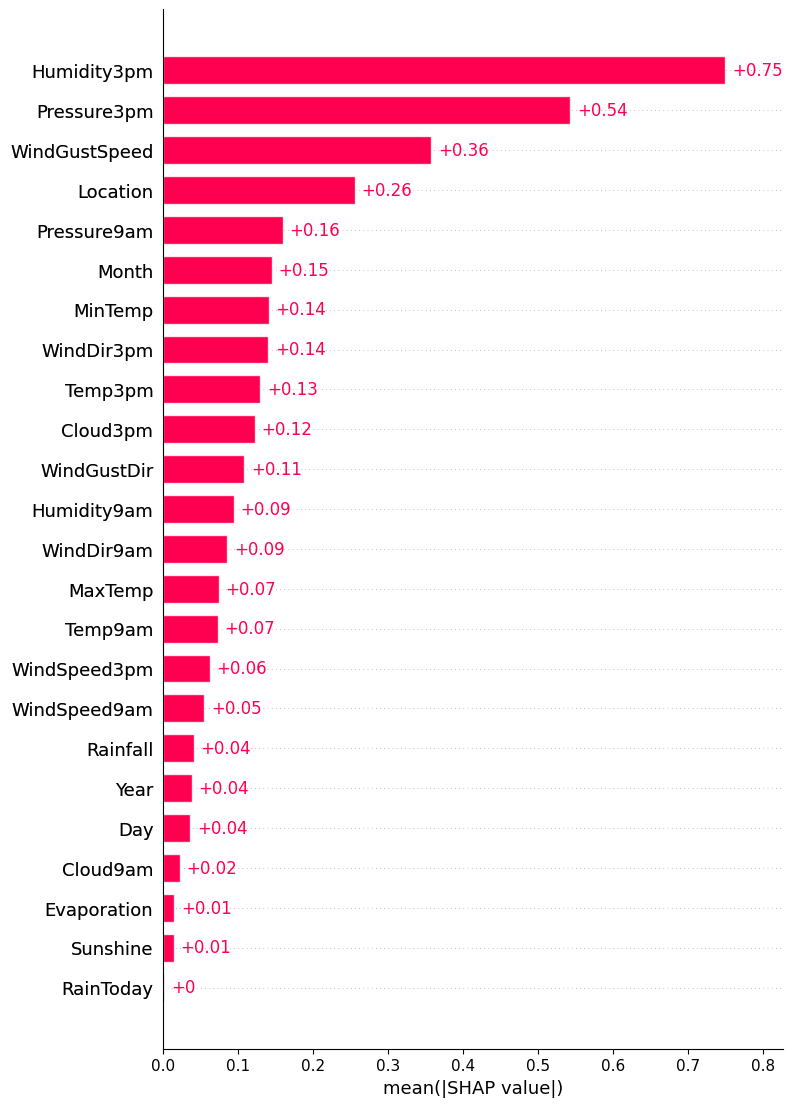

In [66]:
te_df_shap_values = tree_explainer(X_cat_train_cb)
shap_bp = shap.plots.bar(te_df_shap_values, max_display=X_cat_train_cb.shape[1])

Каждому признаку соответствует свой элемент диаграммы, размер которого отражает среднее $SHAP$‑значение. Например, у нас получилось, что самое большое среднее $SHAP$‑значение имеет признак `Humidity3pm`. Это указывает на то, что данный признак оказывает наиболее сильное воздействие на прогнозы модели. Эта информация поможет нам понять то, какие признаки являются наиболее важными в процессе принятия решений, реализуемом моделью.

#### Локальный bar plot для одного объекта

Эта диаграмма позволит нам визуализировать индивидуальные $SHAP$-значения каждого образца в наборе данных. Построим диаграмму для $3$ образца.

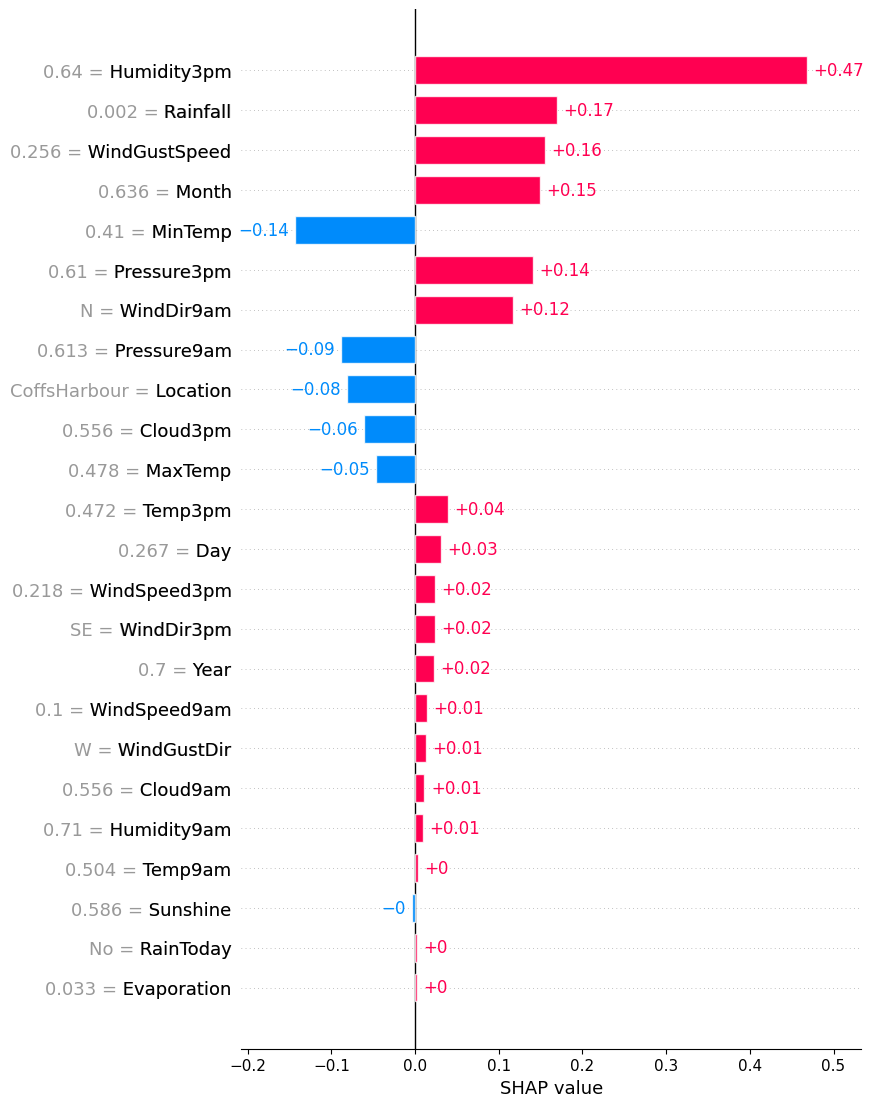

In [67]:
shap_bp = shap.plots.bar(te_df_shap_values[3], max_display=X_cat_train_cb.shape[1])

#### Cohort bar plot

API Exaples: [cohort bar plot](https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/bar.html#Cohort-bar-plot).

Данный график отображает важность признаков в разрезе классов друго признака.

In [68]:
X_cat_train_cb[cat_cols_cb].nunique()

Location       49
WindGustDir    16
WindDir9am     16
WindDir3pm     16
RainToday       2
dtype: int64

Выберем `RainToday` для наглядности (всего 2 уникальных значения).

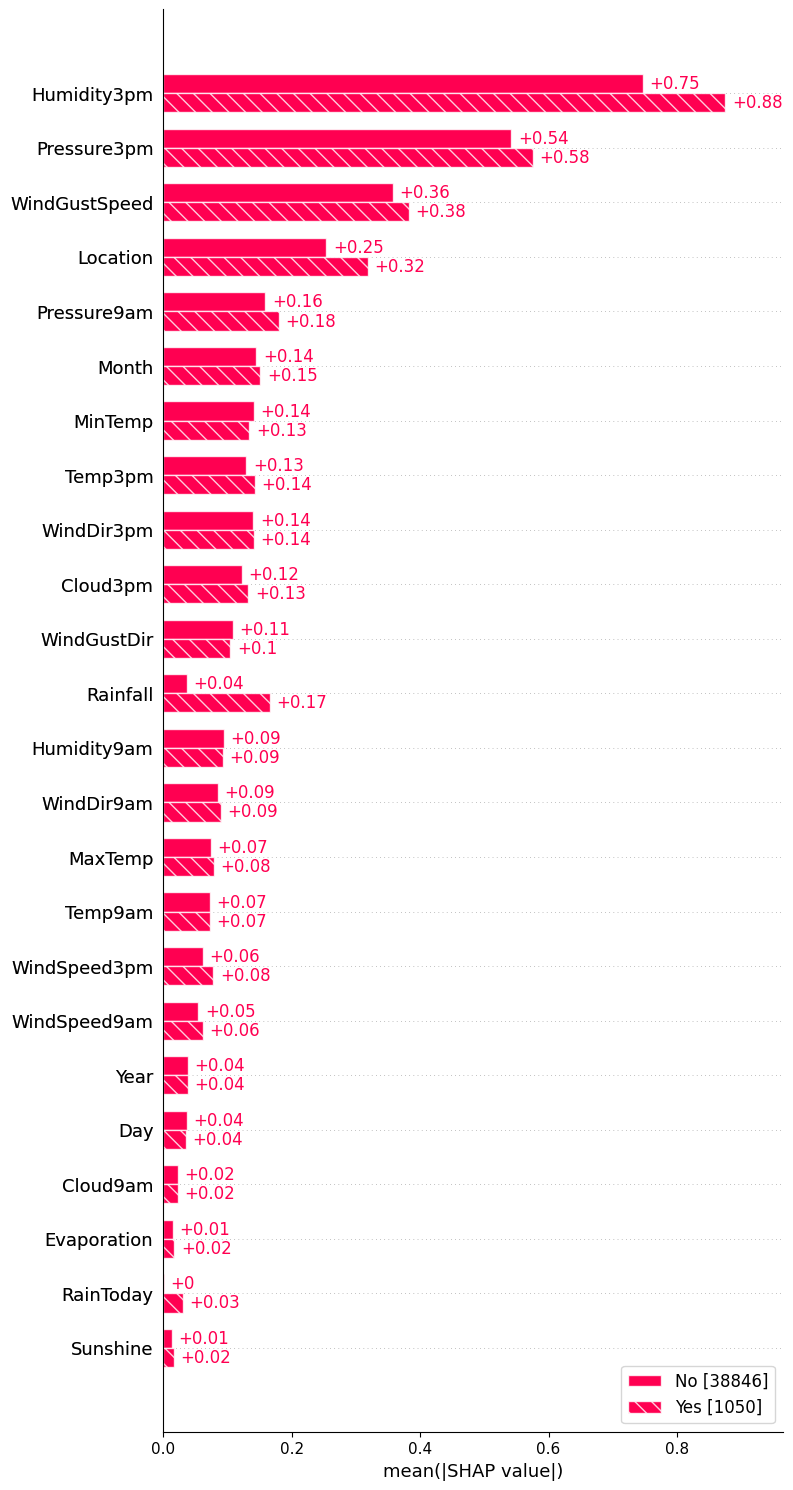

In [69]:
cohort_col_values = X_cat_train_cb['RainToday'].to_numpy()
shap.plots.bar(te_df_shap_values.cohorts(cohort_col_values).abs.mean(0), max_display=X_cat_train_cb.shape[1])

#### Waterfall plot

API Reference: [shap.plots.waterfall](https://shap.readthedocs.io/en/latest/generated/shap.plots.waterfall.html).

API Examples: [waterfall plot](https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/waterfall.html).

Эта диаграмма позволяет нам визуализировать индивидуальные $SHAP$-значения каждого образца в наборе данных. Построим диаграмму для $3$ образца.

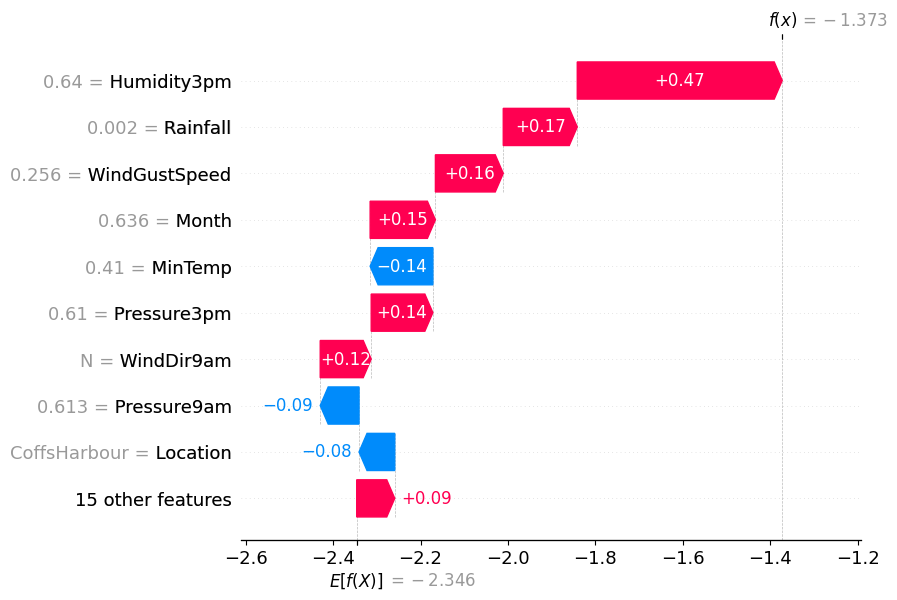

In [70]:
shap.plots.waterfall(te_df_shap_values[3])

Если сложить все эти значения, положительные и отрицательные, с $-2.346$, то получится спрогнозированное значение $-1.373$. Наибольшее влияние на прогноз оказывает признак `Humidity3pm`.

#### Scatter plot

API Reference: [shap.plots.scatter](https://shap.readthedocs.io/en/latest/generated/shap.plots.scatter.html).

API Examples: [shap.plots.scatter](https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/scatter.html).

Для того чтобы лучше понять взаимоотношения между отдельными значениями признаков и их $SHAP$‑значениями, можно создать диаграмму зависимости `shap.plots.scatter`. Это диаграмма, которая раскрывает взаимоотношения между $SHAP$‑значениями и значениями признаков для отдельных признаков. Ось $X$ это значение признака, ось $Y$ &ndash; его $SHAP$-значение.

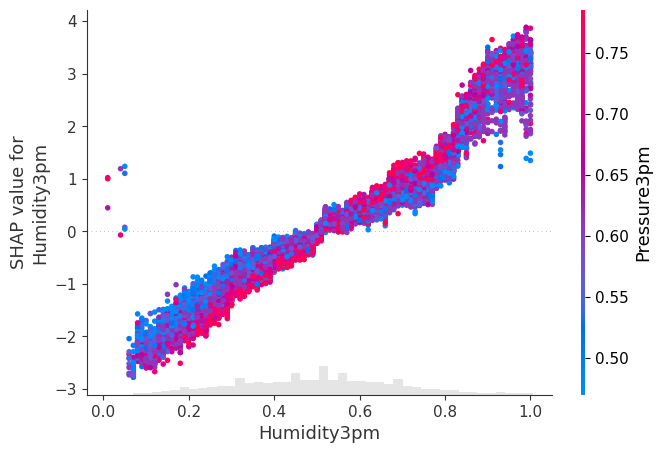

In [71]:
shap.plots.scatter(te_df_shap_values[:, "Humidity3pm"], color=te_df_shap_values[:, "Pressure3pm"])

На графике можно увидеть корреляцию между `Humidity3pm` и `Pressure3pm`.

Также можно проанализировать признак относительно себя самого.

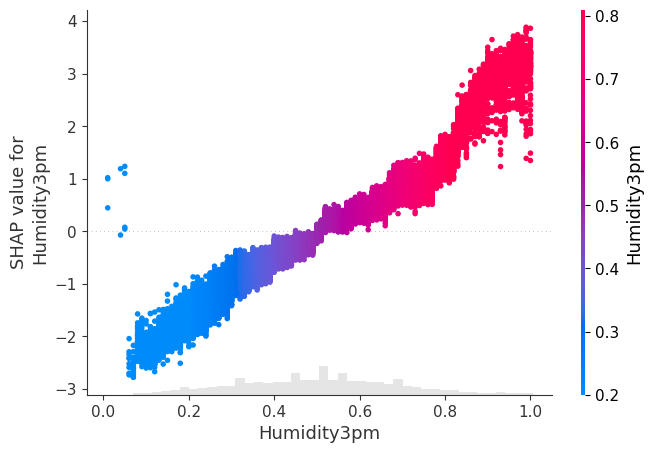

In [72]:
shap.plots.scatter(te_df_shap_values[:, "Humidity3pm"], color=te_df_shap_values[:, "Humidity3pm"])

#### Beeswarm plot

API Reference: [shap.plots.beeswarm](https://shap.readthedocs.io/en/latest/generated/shap.plots.beeswarm.html).

API Examples: [shap.plots.beeswarm](https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/beeswarm.html).

Диаграмма `shap.plots.beeswarm` &ndash; это полезный инструмент, позволяющий визуализировать все $SHAP$‑значения для каждого признака. По оси $X$ этой диаграммы $SHAP$‑значения сгруппированы по признакам. А цвет точек указывает на соответствующее значение признака. Обычно точки, цвет которых ближе к красному, указывают на более высокие значения признаков.

Диаграмма `shap.plots.beeswarm` может помочь в выявлении важных взаимоотношений между признаками и прогнозами модели. На нашей диаграмме признаки упорядочены по их средним $SHAP$‑значениям.

<Axes: xlabel='SHAP value (impact on model output)'>

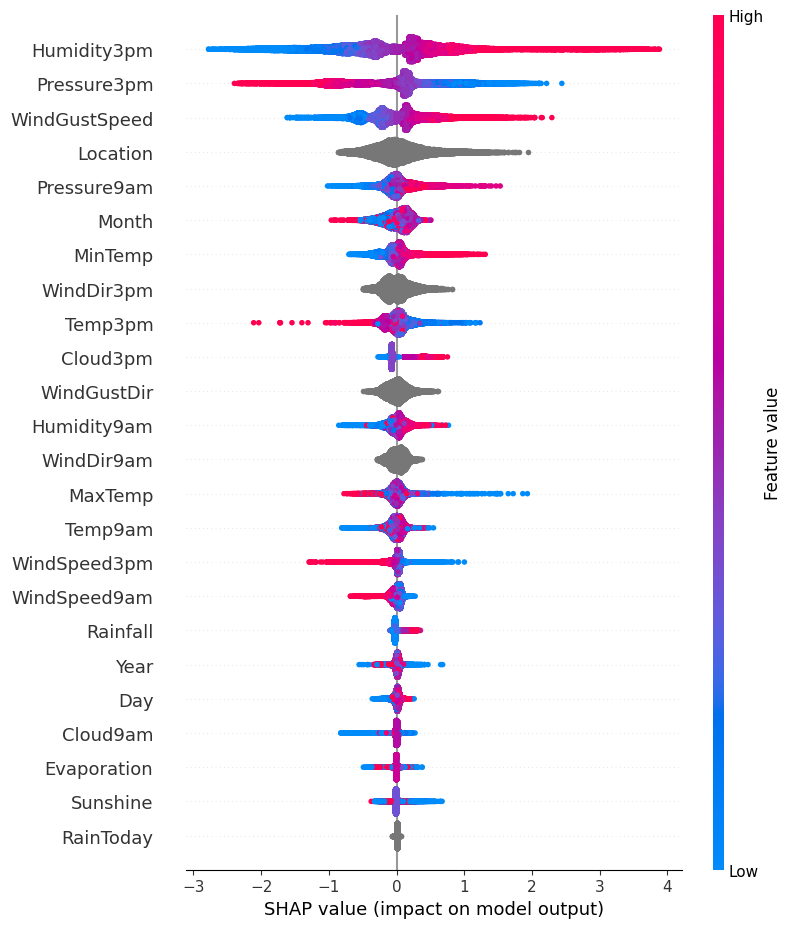

In [73]:
shap.plots.beeswarm(te_df_shap_values, max_display=X_cat_train_cb.shape[1], show=False)

Исследуя $SHAP$‑значения на этой диаграмме, мы можем начать понимать природу взаимоотношений между признаками и спрогнозированной вероятностью дождя завтра. Например, в случае с признаком `Humidity3pm`, видно, что $SHAP$‑значения растут по мере роста значения признака. Это указывает на то, что более высокие значения `Humidity3pm` соответствуют более высокой спрогнозированной вероятностью дождя завтра.

Видна тут и обратная ситуация, связанная с признаками `Pressure3pm` и `MaxTemp`, например. Здесь чем больше значения признаков, тем меньше $SHAP$‑значения. Это наблюдение указывает на то, что более высокие значения `Pressure3pm` и `MaxTemp` связаны с более низкими спрогнозированными вероятностями дождя завтра.

Серым цветом раскрашены категориальные признаки, которые не могут быть соотнесены к численному критерию "меньше-больше".

С $SHAP$ можно визуализировать даже вклад отдельных пикселей в изображении для получения прогноза модели: [Tutorial: Explainable Machine Learning with Python and SHAP](https://mlconference.ai/blog/tutorial-explainable-machine-learning-with-python-and-shap/).

### 6.10 Разное

#### Плагин для вывода времени выполнения кода в ячейке

Удобный плагин для JupyterLab'а [`jupyterlab-execute-time` @ GitHub](https://github.com/deshaw/jupyterlab-execute-time):

```bash
pip install jupyterlab_execute_time
```

> Для Jupyter Notebook сервера есть пакет [Unofficial Jupyter Notebook Extensions](https://jupyter-contrib-nbextensions.readthedocs.io/en/latest/index.html), [Execute Time](https://github.com/ipython-contrib/jupyter_contrib_nbextensions/tree/7672d429957aaefe9f2e71b15e3b78ebb9ba96d1/src/jupyter_contrib_nbextensions/nbextensions/execute_time) &ndash; один из плагинов. Для конфигурирования плагинов можно установить [Jupyter Nbextensions Configurator](https://github.com/Jupyter-contrib/jupyter_nbextensions_configurator).

